In [75]:
# 필요한 패키지 import 하기
import os # 환경 변수나 디렉터리, 파일 등의 OS 자원을 제어할 수 있게 해주는 모듈
import cv2 # OpenCV라이브러리 → 컴퓨터 비전 관련 프로그래밍을 쉽게 할 수 있도록 도와주는 라이브러리
import matplotlib.pyplot as plt # 다양한 데이터를 많은 방법으로 도식화 할 수 있도록 하는 라이브러리
import numpy as np # 다차원 배열을 쉽게 처리하고 효율적으로 사용할 수 있도록 하는 라이브러리
import dlib # 이미지 처리 및 기계 학습, 얼굴인식 등을 할 수 있는 c++ 로 개발된 고성능의 라이브러리 
print("🌫🛸")

🌫🛸


# 사진에 스티커 삽입

### 이미지 업로드

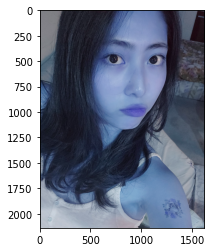

In [76]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker_folder/images/selfie.png' # 본인 이미지가 있는 경로를 가지고 온다.
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
plt.imshow(img_bgr) # 이미지를 출력하기 위해 출력할 이미지를 올려준다. (실제 출력은 하지 않음)
plt.show() # 이미지를 출력해준다. (실제 출력)

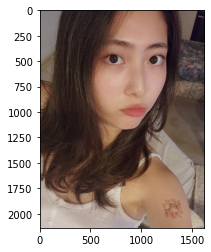

In [77]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb) # 이미지 실제 출력하기 위해 이미지를 올려줌 (원하는 사이즈의 픽셀을 원하는 색으로 채워서 만든 그림이라고 합니다.)
plt.show() # 이미지 실제 출력

### 얼굴탐지 with rectangle

dlib의 face detector는 HOG(Histogram of Oriented Gradients)와 SVM(Support Vector Machine)을 사용해서 얼굴을 찾기.<br>
<br>
이미지의 색상만 가지고는 SVM이 좋은 결과를 내지못함. 하지만 이미지가 HOG를 통해 벡터로 만들어진다면 SVM이 잘 작동함.<br>
<br>
그렇다면 얼굴의 위치는 어떻게 찾을 수 있을까? 바로 <b>sliding window</b>를 사용.
sliding window는 작은 영역(window)을 이동해가며 확인하는 방법<br>
큰 이미지의 작은 영역을 잘라 얼굴이 있는지 확인하고, 다시 작은 영역을 옆으로 옮겨 얼굴이 있는지 확인하는 방식<br>
이미지가 크면 클수록 오래걸리는 단점이 있습니다. 바로 이 지점이 딥러닝이 필요해지는 이유.<br>
<br>
image pyramid <br>
일반적으로는 고정된 이미지 사이즈를 작업을 하지만, 때때로 동일한 이미지에 대해서 다양한 사이즈를 가지고 작업을 해야 하는 경우가 있습니다. 만일, 이미지에서 얼굴을 찾을 경우에 얼굴의 사이즈를 확신할 수 없습니다. 이럴 경우에는 원본 이미지에 대한 다양한 사이즈에서 얼굴을 찾는다면 좀더 정확하고 확실한 이미지를 찾을 수 있습니다. 이처럼 동일 이미지의 서로 다른 사이즈의 set을 Image Pyramids라고 합니다
<br>
1. Gaussian Pyramids 
2. Laplacian Pyramids
    Laplacian Pyramid는 Gaussian Pyramid에서 만들어 집니다.

In [78]:
detector_hog = dlib.get_frontal_face_detector()

In [79]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
rects = detector_hog(img_rgb,1) #(image,# of image pyramid - 1: original)

rectangles[[(514, 337) (1313, 1136)]]
left: 514, top: 337, right: 1313, bottom: 1136


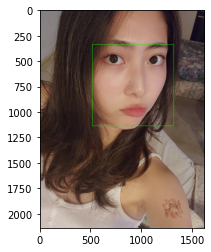

In [80]:
print(rects)
for rect in rects:
    l = rect.left() # left
    t = rect.top() # top
    r = rect.right() # right
    b = rect.bottom() # bottom
    print(f'left: {l}, top: {t}, right: {r}, bottom: {b}')
    
    cv2.rectangle(img_show, (l,t),(r,b),(0,255,0), 2, lineType = cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### 얼굴 이목구비 찾기

Object keypoint estimation 알고리즘<br>
1. top-down : bounding box를 찾고 box 내부의 keypoint를 예측
2. bottom-up : 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화 해서 box 생성
<br>
여기서는 top-down을 사용하여 bounding box를 먼ㄴ저 찾고 box내부의 keypoint를 예측하는 방법을 사용한다.
<br>
논문에 따라 데이터셋 개수가 달라짐.예를 들면, AFLW 데이터셋은 21개를 사용하고 ibug 300w 데이터셋은 68개를 사용합니다.
여기서는 ibug 300w 데이터셋을 사용하여 68개를 사용한다.
<br>
Dlib은 ibug 300-W 데이터셋으로 학습한 pretrained model 을 제공합니다. 학습 알고리즘은 regression tree의 앙상블 모델을 사용 했습니다. 자세한 내용이 궁금하신 분들은 2014년 CVPR (Computer Vision and Pattern Recognition) 에 발표한 논문One Millisecond Face Alignment with an Ensemble of Regression Trees 을 참고해 주세요. 오늘은 알고리즘을 이해하지 않아도 괜찮습니다.
<br>
스티커 위치<br>
$x = x_{nose}$ <br>
$ y = y_{nose} - \frac{height}{2}$<br>
스티커 크기<br>
$width = height = width_{bbox}$<br>
스티커의 위치를 얼굴의 윗 쪽에 놓고 싶은데 왜 스티커의 y좌표는 '코'의 y좌표에서 'height/2' 값을 뺀 값으로 설정한 것일까요?<br>
사진의 맨 위 y 좌표 값이 0이고 사진의 밑으로 내려갈수록 y 좌표 값이 커지기 때문<br>

In [81]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
    # dlib 라이브러리의 shape_predictor 함수를 이용하여 모델을 불러옴
    # landmark_predictor는 RGB이미지와 dlib.rectangle를 입력 받고 dlib.full_object_detection를 반환
    # dlib.rectangle: 내부를 예측하는 박스
    # dlib.full_object_detection: 각 구성 요소의 위치와, 이미지 상의 객체의 위치를 나타냄

In [82]:
list_landmarks = [] 

# 얼굴 영역 박스 마다 face landmark를 찾아내고 저장하기
for rect in rects:
    points = landmark_predictor(img_rgb, rect)
        # 모든 landmark의 위치정보를 points 변수에 저장
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        # 각각의 landmark 위치정보를 (x,y) 형태로 변환하여 list_points 리스트로 저장
    list_landmarks.append(list_points)
        # list_landmarks에 랜드마크 리스트를 저장

print(len(list_landmarks[0]))
    # 얼굴이 n개인 경우 list_landmarks는 n개의 원소를 갖고
    # 각 원소는 68개의 랜드마크 위치가 나열된 list 
    # list_landmarks의 원소가 1개이므로 list_landmarks[1]을 호출하면 IndexError가 발생

68


In [83]:
print(list_landmarks)

[[(390, 461), (388, 597), (401, 730), (436, 853), (499, 964), (584, 1050), (676, 1117), (778, 1170), (869, 1175), (945, 1148), (1004, 1075), (1066, 999), (1127, 914), (1181, 821), (1225, 725), (1245, 621), (1246, 516), (562, 392), (646, 359), (737, 353), (826, 369), (909, 400), (1049, 414), (1112, 397), (1171, 382), (1226, 382), (1261, 411), (976, 523), (979, 613), (985, 702), (991, 792), (874, 834), (918, 848), (960, 860), (997, 850), (1031, 831), (640, 482), (705, 445), (776, 452), (826, 517), (764, 528), (693, 520), (1049, 523), (1097, 460), (1159, 457), (1198, 491), (1164, 529), (1102, 533), (787, 985), (857, 953), (920, 925), (950, 936), (977, 924), (1003, 947), (1019, 974), (995, 1007), (967, 1032), (935, 1041), (900, 1041), (846, 1025), (812, 984), (913, 974), (944, 975), (971, 969), (996, 976), (971, 968), (942, 976), (911, 977)]]


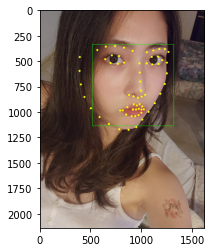

In [84]:
for point in list_landmarks[0]:
    cv2.circle(img_show, point, 10, (0,255,255), -1)
    # 이미지위에 크기가 2이고 0-255 색으로 내부가 채워진(-1) 원을 그림
    
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### 얼굴에 스티커 적용

In [85]:
# zip() : 두 그룹의 데이터를 서로 엮어주는 파이썬의 내장 함수
# rects와 list_landmarks 데이터를 엮어 주었음
# rects : 얼굴 영역을 저장하고 있는 값
# → rectangles[[(514, 337) (1313, 1136)]]
# list_landmarks : 68개의 랜드마크 값 저장(이목구비 위치(x,y))
for rect, landmark in zip(rects, list_landmarks): # 얼굴 영역을 저장하고 있는 값과 68개의 랜드마크를 저장하고 있는 값으로 반복문 실행
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0] # 이미지에서 코 부위의 x값
    y = landmark[30][1] - rect.height()//2 # 이미지에서 코 부위의 y값 - 얼굴 영역의 세로를 차지하는 픽셀의 수//2 → (437, 182-(186+1//2))
    w = h = rect.width() # 얼굴 영역의 가로를 차지하는 픽셀의 수 (531-345+1) → max(x) - min(x) +1(픽셀의 수 이기 때문에 1을 더해줌 → 픽셀 수는 점 하나로도 1이 됨)
    print (f'(x,y) : ({x},{y})')
    print (f'(w,h) : ({w},{h})')

(991, 792)
(x,y) : (991,392)
(w,h) : (800,800)


(800, 800, 3)


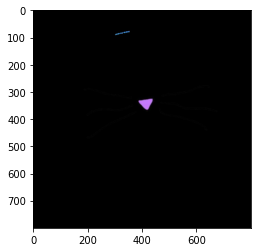

In [98]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whisker.png' # 고양이 수염 이미지의 경로
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러오기
img_sticker = cv2.resize(img_sticker, (w,h)) # 스티커 이미지 조정 → w,h는 얼굴 영역의 가로를 차지하는 픽셀의 수
print (img_sticker.shape) # 사이즈를 조정한 고양이 수염 이미지의 차원 확인
plt.imshow(img_sticker)
plt.show()

In [99]:
refined_x = x - w // 2 
refined_y = y # 코위치에 와있으면 하기 때문에 코 위치로 좌표를 그대로 둔다.
# 즉, refined_x, refined_y값에서 코양이 수염이 시작됨
print (f'(x,y) : ({refined_x},{refined_y})') 

(x,y) : (591,392)


In [100]:
# 고양이 수염 이미지가 이미지 밖에서 시작하지 않도록 조정이 필요함
# 좌표 순서가 y,x임에 유의한다. (y,x,rgb channel)
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :] 
    refined_y = 0

print (f'(x,y) : ({refined_x},{refined_y})')

(x,y) : (591,392)


In [101]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
# 고양이 수염 이미지에서 사용할 부분은 0이 아닌 색이 있는 부분을 사용합니다.
# 고양이 수염 이미지에서 0이 나오는 부분은 흰색이라는 뜻, 즉 이미지가 없다는 소리임.
# sticker_area는 원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지입니다.
# 즉, 고양이 수염 이미지에서 고양이 수염 이미지가 없는 부분은 원본 이미지에서 미리 잘라놓은 sticker_area(스티커 적용할 부분 만큼 원본 이미지에서 자른 이미지)를 적용하고,
# 나머지 부분은 스티커로 채워주면 됨
# np.where는 조건에 해당하는 인덱스만 찾아서 값을 적용하는 방법이다.
# 아래 코드에서는 img_sticker가 0일 경우(고양이 수염 이미지에서 고양이 수염 부분 제외한 나머지 이미지)에는 sticker_area(원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지)를 적용하고,
# 나머지 부분은 img_sticker(고양이 수염 이미지)를 적용한다.
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

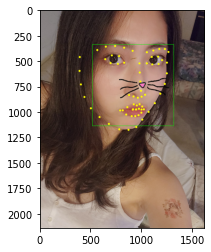

In [102]:
# 고양이 수염 이미지를 적용한 이미지를 보여준다.
# img_show에 고양이 수염 이미지를 덧붙인 이미지가 나오게 된다.)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

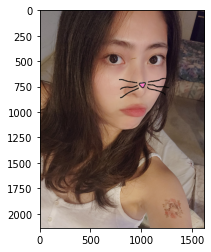

In [103]:
# 고양이 수염 이미지
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)


plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)) # rgb만 적용해놓은 원본 이미지에 고양이 수염 이미지를 덮어 씌운 이미지가 나오게 된다.
plt.show()

# 다른 각도, 다른 거리, 다른 밝기 등에 따른 카메라 스티커앱 적용

다양한 사진들을 실험해보기위해 위의 방법들을 함수로 만들어 활용해보았다.

In [104]:
# path를 통해 그림 array 반환
def get_pic_arr(path):
    my_image_path = path
    img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
    img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
    #RGB 이미지로 바꾸는 것을 잊지마세요. 
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    return img_bgr, img_show, img_rgb

In [105]:
# the function: making rectangle arr
def make_rects(img_rgb):
    detector_hog = dlib.get_frontal_face_detector()
    rects = detector_hog(img_rgb,1) #(image,# of image pyramid - 1: original)
    return rects

In [106]:
# make feature points
def make_points(rects, img_rgb):
    model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
    landmark_predictor = dlib.shape_predictor(model_path)
    # dlib 라이브러리의 shape_predictor 함수를 이용하여 모델을 불러옴
    # landmark_predictor는 RGB이미지와 dlib.rectangle를 입력 받고 dlib.full_object_detection를 반환
    # dlib.rectangle: 내부를 예측하는 박스
    # dlib.full_object_detection: 각 구성 요소의 위치와, 이미지 상의 객체의 위치를 나타냄
    
    list_landmarks = [] 

    # 얼굴 영역 박스 마다 face landmark를 찾아내고 저장하기
    for rect in rects:
        points = landmark_predictor(img_rgb, rect)
            # 모든 landmark의 위치정보를 points 변수에 저장
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
            # 각각의 landmark 위치정보를 (x,y) 형태로 변환하여 list_points 리스트로 저장
        list_landmarks.append(list_points)
            # list_landmarks에 랜드마크 리스트를 저장

    print(len(list_landmarks[0]))
    # 얼굴이 n개인 경우 list_landmarks는 n개의 원소를 갖고
    # 각 원소는 68개의 랜드마크 위치가 나열된 list 
    # list_landmarks의 원소가 1개이므로 list_landmarks[1]을 호출하면 IndexError가 발생
    
    return list_landmarks



In [108]:
def attach_sticker(rects, list_landmarks):
    for rect, landmark in zip(rects, list_landmarks): # 얼굴 영역을 저장하고 있는 값과 68개의 랜드마크를 저장하고 있는 값으로 반복문 실행
        print (landmark[30]) # 코의 index는 30 입니다
        x = landmark[30][0] # 이미지에서 코 부위의 x값
        y = landmark[30][1] - rect.height()//2 # 이미지에서 코 부위의 y값 - 얼굴 영역의 세로를 차지하는 픽셀의 수//2 → (437, 182-(186+1//2))
        w = h = rect.width() # 얼굴 영역의 가로를 차지하는 픽셀의 수 (531-345+1) → max(x) - min(x) +1(픽셀의 수 이기 때문에 1을 더해줌 → 픽셀 수는 점 하나로도 1이 됨)
        print (f'(x,y) : ({x},{y})')
        print (f'(w,h) : ({w},{h})')
    sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whisker.png' # 고양이 수염 이미지의 경로
    img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러오기
    img_sticker = cv2.resize(img_sticker, (w,h)) # 스티커 이미지 조정 → w,h는 얼굴 영역의 가로를 차지하는 픽셀의 수
    print (img_sticker.shape) # 사이즈를 조정한 고양이 수염 이미지의 차원 확인
    refined_x = x - w // 2 
    refined_y = y # 코위치에 와있으면 하기 때문에 코 위치로 좌표를 그대로 둔다.
    # 즉, refined_x, refined_y값에서 코양이 수염이 시작됨
    print (f'(x,y) : ({refined_x},{refined_y})') 
    # 고양이 수염 이미지가 이미지 밖에서 시작하지 않도록 조정이 필요함
    # 좌표 순서가 y,x임에 유의한다. (y,x,rgb channel)
    if refined_x < 0: 
        img_sticker = img_sticker[:, -refined_x:]
        refined_x = 0
    if refined_y < 0:
        img_sticker = img_sticker[-refined_y:, :] 
        refined_y = 0

    print (f'(x,y) : ({refined_x},{refined_y})')
    
    return refined_x, refined_y, img_sticker
    

### 완전 앞

In [141]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/ningning_airport_front.png' # 본인 이미지가 있는 경로를 가지고 온다.
img_bgr_front, img_show_front, img_rgb_front = get_pic_arr(my_image_path)

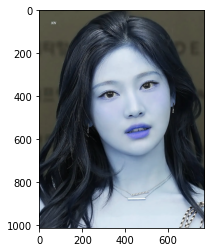

In [142]:
plt.imshow(img_bgr_front) # 이미지를 출력하기 위해 출력할 이미지를 올려준다. (실제 출력은 하지 않음)
plt.show() # 이미지를 출력해준다. (실제 출력)

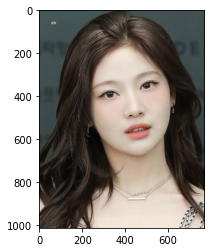

In [143]:
plt.imshow(img_rgb_front) # 이미지 실제 출력하기 위해 이미지를 올려줌 (원하는 사이즈의 픽셀을 원하는 색으로 채워서 만든 그림이라고 합니다.)
plt.show() # 이미지 실제 출력

* 얼굴 사각형 만들기

In [144]:
rects_front = make_rects(img_rgb_front)

rectangles[[(247, 247) (632, 632)]]
left: 247, top: 247, right: 632, bottom: 632


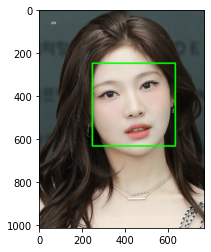

In [145]:
print(rects_front)
for rect in rects_front:
    l = rect.left() # left
    t = rect.top() # top
    r = rect.right() # right
    b = rect.bottom() # bottom
    print(f'left: {l}, top: {t}, right: {r}, bottom: {b}')
    
    cv2.rectangle(img_show_front, (l,t),(r,b),(0,255,0), 5, lineType = cv2.LINE_AA)

img_show_rgb_front = cv2.cvtColor(img_show_front, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb_front)
plt.show()

* 얼굴 이목구비 점 생성

In [146]:
list_points_front = make_points(rects_front, img_rgb_front)

68


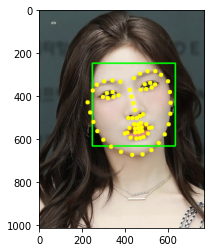

In [147]:
for point in list_points_front[0]:
    cv2.circle(img_show_front, point, 10, (0,255,255), -1)
    # 이미지위에 크기가 2이고 0-255 색으로 내부가 채워진(-1) 원을 그림
    
img_show_rgb_front = cv2.cvtColor(img_show_front, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb_front)
plt.show()

* 얼굴에 스티커 붙이기

In [148]:
refined_x_f, refined_y_f, img_sticker_f = attach_sticker(rects_front, list_points_front)

(445, 465)
(x,y) : (445,272)
(w,h) : (386,386)
(386, 386, 3)
(x,y) : (252,272)
(x,y) : (252,272)


In [149]:
sticker_area_front = img_show_front[refined_y_f:refined_y_f+img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]]
# 고양이 수염 이미지에서 사용할 부분은 0이 아닌 색이 있는 부분을 사용합니다.
# 고양이 수염 이미지에서 0이 나오는 부분은 흰색이라는 뜻, 즉 이미지가 없다는 소리임.
# sticker_area는 원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지입니다.
# 즉, 고양이 수염 이미지에서 고양이 수염 이미지가 없는 부분은 원본 이미지에서 미리 잘라놓은 sticker_area(스티커 적용할 부분 만큼 원본 이미지에서 자른 이미지)를 적용하고,
# 나머지 부분은 스티커로 채워주면 됨
# np.where는 조건에 해당하는 인덱스만 찾아서 값을 적용하는 방법이다.
# 아래 코드에서는 img_sticker가 0일 경우(고양이 수염 이미지에서 고양이 수염 부분 제외한 나머지 이미지)에는 sticker_area(원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지)를 적용하고,
# 나머지 부분은 img_sticker(고양이 수염 이미지)를 적용한다.
img_show_front[refined_y_f:refined_y_f+img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]] = \
    np.where(img_sticker_f==0,sticker_area_front,img_sticker_f).astype(np.uint8)

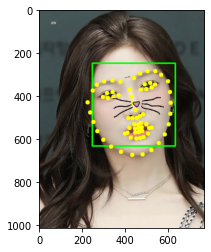

In [150]:
# 고양이 수염 이미지를 적용한 이미지를 보여준다.
# img_show에 고양이 수염 이미지를 덧붙인 이미지가 나오게 된다.)
plt.imshow(cv2.cvtColor(img_show_front, cv2.COLOR_BGR2RGB))
plt.show()

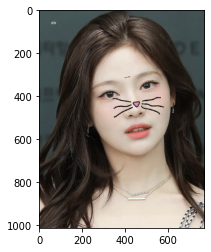

In [151]:
# 고양이 수염 이미지
sticker_area_front = img_bgr_front[refined_y_f:refined_y_f +img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]]
img_bgr_front[refined_y_f:refined_y_f +img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]] = \
    np.where(img_sticker_f==0,sticker_area_front,img_sticker_f).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr_front, cv2.COLOR_BGR2RGB)) # rgb만 적용해놓은 원본 이미지에 고양이 수염 이미지를 덮어 씌운 이미지가 나오게 된다.
plt.show()

### 약간 옆

In [152]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/ningning_side_little.png' # 본인 이미지가 있는 경로를 가지고 온다.
img_bgr_front, img_show_front, img_rgb_front = get_pic_arr(my_image_path)

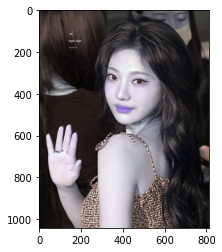

In [153]:
plt.imshow(img_bgr_front) # 이미지를 출력하기 위해 출력할 이미지를 올려준다. (실제 출력은 하지 않음)
plt.show() # 이미지를 출력해준다. (실제 출력)

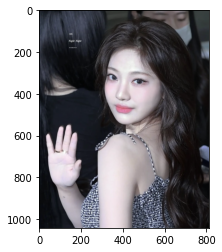

In [154]:
plt.imshow(img_rgb_front) # 이미지 실제 출력하기 위해 이미지를 올려줌 (원하는 사이즈의 픽셀을 원하는 색으로 채워서 만든 그림이라고 합니다.)
plt.show() # 이미지 실제 출력

* 얼굴 사각형 만들기

In [155]:
rects_front = make_rects(img_rgb_front)

rectangles[[(241, 206) (562, 527)]]
left: 241, top: 206, right: 562, bottom: 527


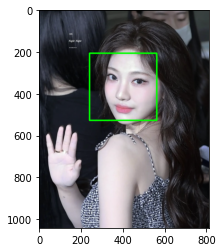

In [156]:
print(rects_front)
for rect in rects_front:
    l = rect.left() # left
    t = rect.top() # top
    r = rect.right() # right
    b = rect.bottom() # bottom
    print(f'left: {l}, top: {t}, right: {r}, bottom: {b}')
    
    cv2.rectangle(img_show_front, (l,t),(r,b),(0,255,0), 5, lineType = cv2.LINE_AA)

img_show_rgb_front = cv2.cvtColor(img_show_front, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb_front)
plt.show()

* 얼굴 이목구비 점 생성

In [157]:
list_points_front = make_points(rects_front, img_rgb_front)

68


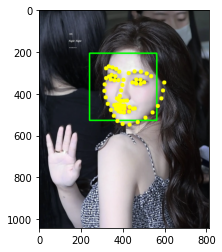

In [158]:
for point in list_points_front[0]:
    cv2.circle(img_show_front, point, 10, (0,255,255), -1)
    # 이미지위에 크기가 2이고 0-255 색으로 내부가 채워진(-1) 원을 그림
    
img_show_rgb_front = cv2.cvtColor(img_show_front, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb_front)
plt.show()

* 얼굴에 스티커 붙이기

In [159]:
refined_x_f, refined_y_f, img_sticker_f = attach_sticker(rects_front, list_points_front)

(386, 410)
(x,y) : (386,249)
(w,h) : (322,322)
(322, 322, 3)
(x,y) : (225,249)
(x,y) : (225,249)


In [160]:
sticker_area_front = img_show_front[refined_y_f:refined_y_f+img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]]
# 고양이 수염 이미지에서 사용할 부분은 0이 아닌 색이 있는 부분을 사용합니다.
# 고양이 수염 이미지에서 0이 나오는 부분은 흰색이라는 뜻, 즉 이미지가 없다는 소리임.
# sticker_area는 원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지입니다.
# 즉, 고양이 수염 이미지에서 고양이 수염 이미지가 없는 부분은 원본 이미지에서 미리 잘라놓은 sticker_area(스티커 적용할 부분 만큼 원본 이미지에서 자른 이미지)를 적용하고,
# 나머지 부분은 스티커로 채워주면 됨
# np.where는 조건에 해당하는 인덱스만 찾아서 값을 적용하는 방법이다.
# 아래 코드에서는 img_sticker가 0일 경우(고양이 수염 이미지에서 고양이 수염 부분 제외한 나머지 이미지)에는 sticker_area(원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지)를 적용하고,
# 나머지 부분은 img_sticker(고양이 수염 이미지)를 적용한다.
img_show_front[refined_y_f:refined_y_f+img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]] = \
    np.where(img_sticker_f==0,sticker_area_front,img_sticker_f).astype(np.uint8)

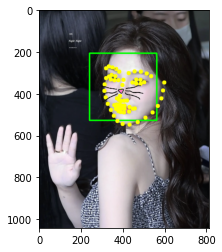

In [161]:
# 고양이 수염 이미지를 적용한 이미지를 보여준다.
# img_show에 고양이 수염 이미지를 덧붙인 이미지가 나오게 된다.)
plt.imshow(cv2.cvtColor(img_show_front, cv2.COLOR_BGR2RGB))
plt.show()

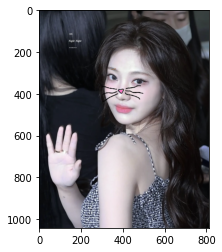

In [162]:
# 고양이 수염 이미지
sticker_area_front = img_bgr_front[refined_y_f:refined_y_f +img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]]
img_bgr_front[refined_y_f:refined_y_f +img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]] = \
    np.where(img_sticker_f==0,sticker_area_front,img_sticker_f).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr_front, cv2.COLOR_BGR2RGB)) # rgb만 적용해놓은 원본 이미지에 고양이 수염 이미지를 덮어 씌운 이미지가 나오게 된다.
plt.show()

### 더 옆으로 돌린 모습

In [257]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/ningning_side_profile.png' # 본인 이미지가 있는 경로를 가지고 온다.
img_bgr_front, img_show_front, img_rgb_front = get_pic_arr(my_image_path)

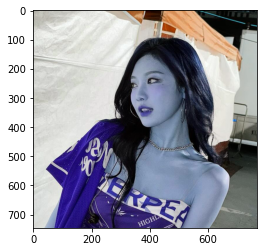

In [258]:
plt.imshow(img_bgr_front) # 이미지를 출력하기 위해 출력할 이미지를 올려준다. (실제 출력은 하지 않음)
plt.show() # 이미지를 출력해준다. (실제 출력)

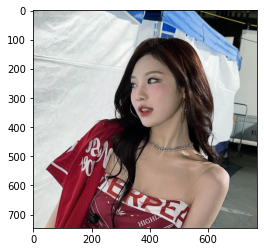

In [259]:
plt.imshow(img_rgb_front) # 이미지 실제 출력하기 위해 이미지를 올려줌 (원하는 사이즈의 픽셀을 원하는 색으로 채워서 만든 그림이라고 합니다.)
plt.show() # 이미지 실제 출력

* 얼굴 사각형 만들기

In [260]:
rects_front = make_rects(img_rgb_front)

rectangles[[(266, 167) (489, 390)]]
left: 266, top: 167, right: 489, bottom: 390


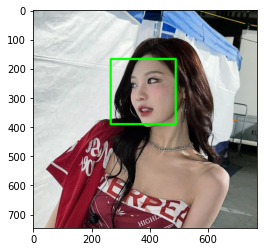

In [261]:
print(rects_front)
for rect in rects_front:
    l = rect.left() # left
    t = rect.top() # top
    r = rect.right() # right
    b = rect.bottom() # bottom
    print(f'left: {l}, top: {t}, right: {r}, bottom: {b}')
    
    cv2.rectangle(img_show_front, (l,t),(r,b),(0,255,0), 5, lineType = cv2.LINE_AA)

img_show_rgb_front = cv2.cvtColor(img_show_front, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb_front)
plt.show()

* 얼굴 이목구비 점 생성

In [262]:
list_points_front = make_points(rects_front, img_rgb_front)

68


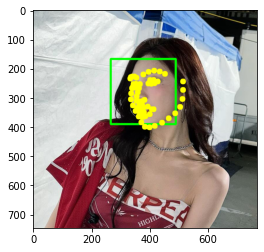

In [263]:
for point in list_points_front[0]:
    cv2.circle(img_show_front, point, 10, (0,255,255), -1)
    # 이미지위에 크기가 2이고 0-255 색으로 내부가 채워진(-1) 원을 그림
    
img_show_rgb_front = cv2.cvtColor(img_show_front, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb_front)
plt.show()

* 얼굴에 스티커 붙이기

In [264]:
refined_x_f, refined_y_f, img_sticker_f = attach_sticker(rects_front, list_points_front)

(355, 295)
(x,y) : (355,183)
(w,h) : (224,224)
(224, 224, 3)
(x,y) : (243,183)
(x,y) : (243,183)


In [265]:
sticker_area_front = img_show_front[refined_y_f:refined_y_f+img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]]
# 고양이 수염 이미지에서 사용할 부분은 0이 아닌 색이 있는 부분을 사용합니다.
# 고양이 수염 이미지에서 0이 나오는 부분은 흰색이라는 뜻, 즉 이미지가 없다는 소리임.
# sticker_area는 원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지입니다.
# 즉, 고양이 수염 이미지에서 고양이 수염 이미지가 없는 부분은 원본 이미지에서 미리 잘라놓은 sticker_area(스티커 적용할 부분 만큼 원본 이미지에서 자른 이미지)를 적용하고,
# 나머지 부분은 스티커로 채워주면 됨
# np.where는 조건에 해당하는 인덱스만 찾아서 값을 적용하는 방법이다.
# 아래 코드에서는 img_sticker가 0일 경우(고양이 수염 이미지에서 고양이 수염 부분 제외한 나머지 이미지)에는 sticker_area(원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지)를 적용하고,
# 나머지 부분은 img_sticker(고양이 수염 이미지)를 적용한다.
img_show_front[refined_y_f:refined_y_f+img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]] = \
    np.where(img_sticker_f==0,sticker_area_front,img_sticker_f).astype(np.uint8)

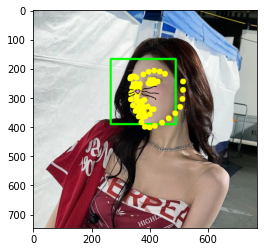

In [266]:
# 고양이 수염 이미지를 적용한 이미지를 보여준다.
# img_show에 고양이 수염 이미지를 덧붙인 이미지가 나오게 된다.)
plt.imshow(cv2.cvtColor(img_show_front, cv2.COLOR_BGR2RGB))
plt.show()

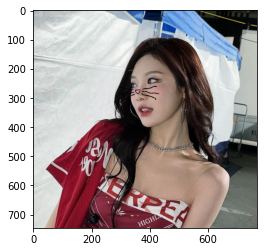

In [267]:
# 고양이 수염 이미지
sticker_area_front = img_bgr_front[refined_y_f:refined_y_f +img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]]
img_bgr_front[refined_y_f:refined_y_f +img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]] = \
    np.where(img_sticker_f==0,sticker_area_front,img_sticker_f).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr_front, cv2.COLOR_BGR2RGB)) # rgb만 적용해놓은 원본 이미지에 고양이 수염 이미지를 덮어 씌운 이미지가 나오게 된다.
plt.show()

### 완전 옆

In [163]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/ningning side profile.png' # 본인 이미지가 있는 경로를 가지고 온다.
img_bgr_front, img_show_front, img_rgb_front = get_pic_arr(my_image_path)

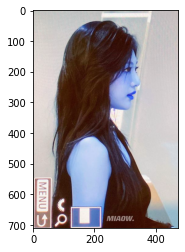

In [164]:
plt.imshow(img_bgr_front) # 이미지를 출력하기 위해 출력할 이미지를 올려준다. (실제 출력은 하지 않음)
plt.show() # 이미지를 출력해준다. (실제 출력)

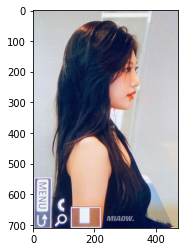

In [165]:
plt.imshow(img_rgb_front) # 이미지 실제 출력하기 위해 이미지를 올려줌 (원하는 사이즈의 픽셀을 원하는 색으로 채워서 만든 그림이라고 합니다.)
plt.show() # 이미지 실제 출력

* 얼굴 사각형 만들기

In [166]:
rects_front = make_rects(img_rgb_front)

rectangles[[(265, 216) (354, 305)]]
left: 265, top: 216, right: 354, bottom: 305


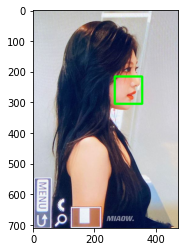

In [167]:
print(rects_front)
for rect in rects_front:
    l = rect.left() # left
    t = rect.top() # top
    r = rect.right() # right
    b = rect.bottom() # bottom
    print(f'left: {l}, top: {t}, right: {r}, bottom: {b}')
    
    cv2.rectangle(img_show_front, (l,t),(r,b),(0,255,0), 5, lineType = cv2.LINE_AA)

img_show_rgb_front = cv2.cvtColor(img_show_front, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb_front)
plt.show()

* 얼굴 이목구비 점 생성

In [168]:
list_points_front = make_points(rects_front, img_rgb_front)

68


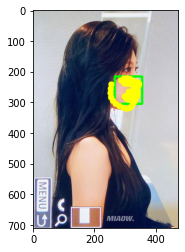

In [169]:
for point in list_points_front[0]:
    cv2.circle(img_show_front, point, 10, (0,255,255), -1)
    # 이미지위에 크기가 2이고 0-255 색으로 내부가 채워진(-1) 원을 그림
    
img_show_rgb_front = cv2.cvtColor(img_show_front, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb_front)
plt.show()

* 얼굴에 스티커 붙이기

In [170]:
refined_x_f, refined_y_f, img_sticker_f = attach_sticker(rects_front, list_points_front)

(328, 260)
(x,y) : (328,215)
(w,h) : (90,90)
(90, 90, 3)
(x,y) : (283,215)
(x,y) : (283,215)


In [171]:
sticker_area_front = img_show_front[refined_y_f:refined_y_f+img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]]
# 고양이 수염 이미지에서 사용할 부분은 0이 아닌 색이 있는 부분을 사용합니다.
# 고양이 수염 이미지에서 0이 나오는 부분은 흰색이라는 뜻, 즉 이미지가 없다는 소리임.
# sticker_area는 원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지입니다.
# 즉, 고양이 수염 이미지에서 고양이 수염 이미지가 없는 부분은 원본 이미지에서 미리 잘라놓은 sticker_area(스티커 적용할 부분 만큼 원본 이미지에서 자른 이미지)를 적용하고,
# 나머지 부분은 스티커로 채워주면 됨
# np.where는 조건에 해당하는 인덱스만 찾아서 값을 적용하는 방법이다.
# 아래 코드에서는 img_sticker가 0일 경우(고양이 수염 이미지에서 고양이 수염 부분 제외한 나머지 이미지)에는 sticker_area(원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지)를 적용하고,
# 나머지 부분은 img_sticker(고양이 수염 이미지)를 적용한다.
img_show_front[refined_y_f:refined_y_f+img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]] = \
    np.where(img_sticker_f==0,sticker_area_front,img_sticker_f).astype(np.uint8)

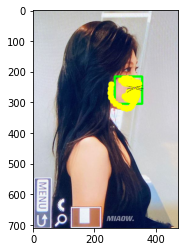

In [172]:
# 고양이 수염 이미지를 적용한 이미지를 보여준다.
# img_show에 고양이 수염 이미지를 덧붙인 이미지가 나오게 된다.)
plt.imshow(cv2.cvtColor(img_show_front, cv2.COLOR_BGR2RGB))
plt.show()

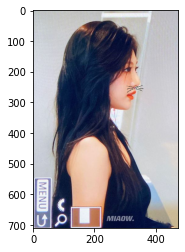

In [173]:
# 고양이 수염 이미지
sticker_area_front = img_bgr_front[refined_y_f:refined_y_f +img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]]
img_bgr_front[refined_y_f:refined_y_f +img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]] = \
    np.where(img_sticker_f==0,sticker_area_front,img_sticker_f).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr_front, cv2.COLOR_BGR2RGB)) # rgb만 적용해놓은 원본 이미지에 고양이 수염 이미지를 덮어 씌운 이미지가 나오게 된다.
plt.show()

### 아래 볼때

In [174]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/ningning_looking_down.png' # 본인 이미지가 있는 경로를 가지고 온다.
img_bgr_front, img_show_front, img_rgb_front = get_pic_arr(my_image_path)

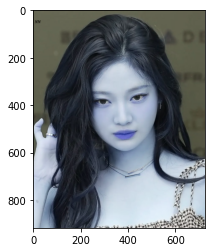

In [175]:
plt.imshow(img_bgr_front) # 이미지를 출력하기 위해 출력할 이미지를 올려준다. (실제 출력은 하지 않음)
plt.show() # 이미지를 출력해준다. (실제 출력)

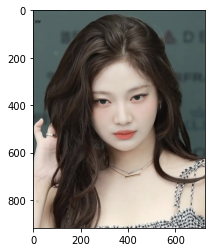

In [176]:
plt.imshow(img_rgb_front) # 이미지 실제 출력하기 위해 이미지를 올려줌 (원하는 사이즈의 픽셀을 원하는 색으로 채워서 만든 그림이라고 합니다.)
plt.show() # 이미지 실제 출력

* 얼굴 사각형 만들기

In [177]:
rects_front = make_rects(img_rgb_front)

rectangles[[(205, 277) (526, 598)]]
left: 205, top: 277, right: 526, bottom: 598


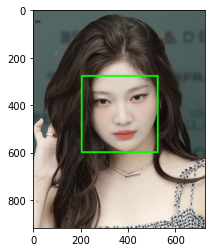

In [178]:
print(rects_front)
for rect in rects_front:
    l = rect.left() # left
    t = rect.top() # top
    r = rect.right() # right
    b = rect.bottom() # bottom
    print(f'left: {l}, top: {t}, right: {r}, bottom: {b}')
    
    cv2.rectangle(img_show_front, (l,t),(r,b),(0,255,0), 5, lineType = cv2.LINE_AA)

img_show_rgb_front = cv2.cvtColor(img_show_front, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb_front)
plt.show()

* 얼굴 이목구비 점 생성

In [179]:
list_points_front = make_points(rects_front, img_rgb_front)

68


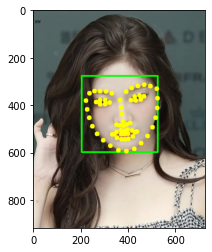

In [180]:
for point in list_points_front[0]:
    cv2.circle(img_show_front, point, 10, (0,255,255), -1)
    # 이미지위에 크기가 2이고 0-255 색으로 내부가 채워진(-1) 원을 그림
    
img_show_rgb_front = cv2.cvtColor(img_show_front, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb_front)
plt.show()

* 얼굴에 스티커 붙이기

In [181]:
refined_x_f, refined_y_f, img_sticker_f = attach_sticker(rects_front, list_points_front)

(379, 468)
(x,y) : (379,307)
(w,h) : (322,322)
(322, 322, 3)
(x,y) : (218,307)
(x,y) : (218,307)


In [182]:
sticker_area_front = img_show_front[refined_y_f:refined_y_f+img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]]
# 고양이 수염 이미지에서 사용할 부분은 0이 아닌 색이 있는 부분을 사용합니다.
# 고양이 수염 이미지에서 0이 나오는 부분은 흰색이라는 뜻, 즉 이미지가 없다는 소리임.
# sticker_area는 원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지입니다.
# 즉, 고양이 수염 이미지에서 고양이 수염 이미지가 없는 부분은 원본 이미지에서 미리 잘라놓은 sticker_area(스티커 적용할 부분 만큼 원본 이미지에서 자른 이미지)를 적용하고,
# 나머지 부분은 스티커로 채워주면 됨
# np.where는 조건에 해당하는 인덱스만 찾아서 값을 적용하는 방법이다.
# 아래 코드에서는 img_sticker가 0일 경우(고양이 수염 이미지에서 고양이 수염 부분 제외한 나머지 이미지)에는 sticker_area(원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지)를 적용하고,
# 나머지 부분은 img_sticker(고양이 수염 이미지)를 적용한다.
img_show_front[refined_y_f:refined_y_f+img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]] = \
    np.where(img_sticker_f==0,sticker_area_front,img_sticker_f).astype(np.uint8)

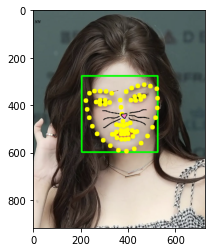

In [183]:
# 고양이 수염 이미지를 적용한 이미지를 보여준다.
# img_show에 고양이 수염 이미지를 덧붙인 이미지가 나오게 된다.)
plt.imshow(cv2.cvtColor(img_show_front, cv2.COLOR_BGR2RGB))
plt.show()

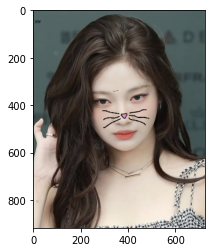

In [184]:
# 고양이 수염 이미지
sticker_area_front = img_bgr_front[refined_y_f:refined_y_f +img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]]
img_bgr_front[refined_y_f:refined_y_f +img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]] = \
    np.where(img_sticker_f==0,sticker_area_front,img_sticker_f).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr_front, cv2.COLOR_BGR2RGB)) # rgb만 적용해놓은 원본 이미지에 고양이 수염 이미지를 덮어 씌운 이미지가 나오게 된다.
plt.show()

### 어두운 빛

In [185]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/ningning_dark_light.png' # 본인 이미지가 있는 경로를 가지고 온다.
img_bgr_front, img_show_front, img_rgb_front = get_pic_arr(my_image_path)

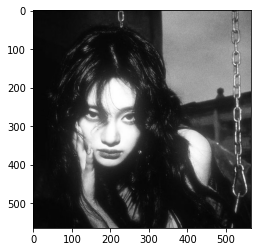

In [186]:
plt.imshow(img_bgr_front) # 이미지를 출력하기 위해 출력할 이미지를 올려준다. (실제 출력은 하지 않음)
plt.show() # 이미지를 출력해준다. (실제 출력)

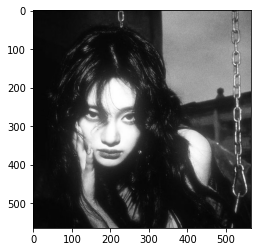

In [187]:
plt.imshow(img_rgb_front) # 이미지 실제 출력하기 위해 이미지를 올려줌 (원하는 사이즈의 픽셀을 원하는 색으로 채워서 만든 그림이라고 합니다.)
plt.show() # 이미지 실제 출력

* 얼굴 사각형 만들기

In [188]:
rects_front = make_rects(img_rgb_front)

rectangles[[(118, 222) (304, 407)]]
left: 118, top: 222, right: 304, bottom: 407


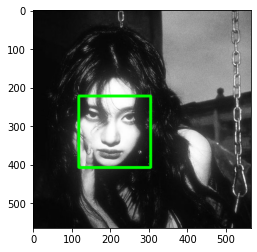

In [189]:
print(rects_front)
for rect in rects_front:
    l = rect.left() # left
    t = rect.top() # top
    r = rect.right() # right
    b = rect.bottom() # bottom
    print(f'left: {l}, top: {t}, right: {r}, bottom: {b}')
    
    cv2.rectangle(img_show_front, (l,t),(r,b),(0,255,0), 5, lineType = cv2.LINE_AA)

img_show_rgb_front = cv2.cvtColor(img_show_front, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb_front)
plt.show()

* 얼굴 이목구비 점 생성

In [190]:
list_points_front = make_points(rects_front, img_rgb_front)

68


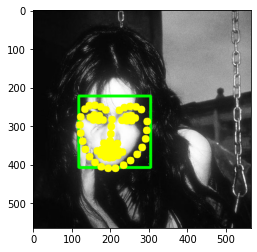

In [191]:
for point in list_points_front[0]:
    cv2.circle(img_show_front, point, 10, (0,255,255), -1)
    # 이미지위에 크기가 2이고 0-255 색으로 내부가 채워진(-1) 원을 그림
    
img_show_rgb_front = cv2.cvtColor(img_show_front, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb_front)
plt.show()

* 얼굴에 스티커 붙이기

In [192]:
refined_x_f, refined_y_f, img_sticker_f = attach_sticker(rects_front, list_points_front)

(199, 338)
(x,y) : (199,245)
(w,h) : (187,187)
(187, 187, 3)
(x,y) : (106,245)
(x,y) : (106,245)


In [193]:
sticker_area_front = img_show_front[refined_y_f:refined_y_f+img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]]
# 고양이 수염 이미지에서 사용할 부분은 0이 아닌 색이 있는 부분을 사용합니다.
# 고양이 수염 이미지에서 0이 나오는 부분은 흰색이라는 뜻, 즉 이미지가 없다는 소리임.
# sticker_area는 원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지입니다.
# 즉, 고양이 수염 이미지에서 고양이 수염 이미지가 없는 부분은 원본 이미지에서 미리 잘라놓은 sticker_area(스티커 적용할 부분 만큼 원본 이미지에서 자른 이미지)를 적용하고,
# 나머지 부분은 스티커로 채워주면 됨
# np.where는 조건에 해당하는 인덱스만 찾아서 값을 적용하는 방법이다.
# 아래 코드에서는 img_sticker가 0일 경우(고양이 수염 이미지에서 고양이 수염 부분 제외한 나머지 이미지)에는 sticker_area(원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지)를 적용하고,
# 나머지 부분은 img_sticker(고양이 수염 이미지)를 적용한다.
img_show_front[refined_y_f:refined_y_f+img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]] = \
    np.where(img_sticker_f==0,sticker_area_front,img_sticker_f).astype(np.uint8)

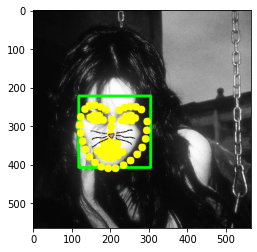

In [194]:
# 고양이 수염 이미지를 적용한 이미지를 보여준다.
# img_show에 고양이 수염 이미지를 덧붙인 이미지가 나오게 된다.)
plt.imshow(cv2.cvtColor(img_show_front, cv2.COLOR_BGR2RGB))
plt.show()

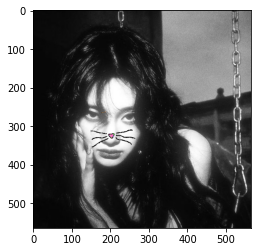

In [195]:
# 고양이 수염 이미지
sticker_area_front = img_bgr_front[refined_y_f:refined_y_f +img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]]
img_bgr_front[refined_y_f:refined_y_f +img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]] = \
    np.where(img_sticker_f==0,sticker_area_front,img_sticker_f).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr_front, cv2.COLOR_BGR2RGB)) # rgb만 적용해놓은 원본 이미지에 고양이 수염 이미지를 덮어 씌운 이미지가 나오게 된다.
plt.show()

* 위의 정면 보는 사진의 밝기를 낮춘 사진

In [196]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/ningning_front_dark.png' # 본인 이미지가 있는 경로를 가지고 온다.
img_bgr_front, img_show_front, img_rgb_front = get_pic_arr(my_image_path)

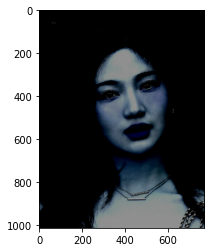

In [197]:
plt.imshow(img_bgr_front) # 이미지를 출력하기 위해 출력할 이미지를 올려준다. (실제 출력은 하지 않음)
plt.show() # 이미지를 출력해준다. (실제 출력)

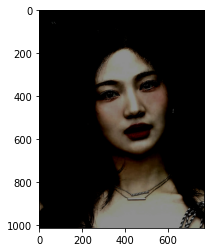

In [198]:
plt.imshow(img_rgb_front) # 이미지 실제 출력하기 위해 이미지를 올려줌 (원하는 사이즈의 픽셀을 원하는 색으로 채워서 만든 그림이라고 합니다.)
plt.show() # 이미지 실제 출력

* 얼굴 사각형 만들기

In [199]:
rects_front = make_rects(img_rgb_front)

rectangles[[(247, 247) (632, 632)]]
left: 247, top: 247, right: 632, bottom: 632


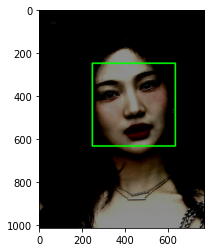

In [200]:
print(rects_front)
for rect in rects_front:
    l = rect.left() # left
    t = rect.top() # top
    r = rect.right() # right
    b = rect.bottom() # bottom
    print(f'left: {l}, top: {t}, right: {r}, bottom: {b}')
    
    cv2.rectangle(img_show_front, (l,t),(r,b),(0,255,0), 5, lineType = cv2.LINE_AA)

img_show_rgb_front = cv2.cvtColor(img_show_front, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb_front)
plt.show()

* 얼굴 이목구비 점 생성

In [201]:
list_points_front = make_points(rects_front, img_rgb_front)

68


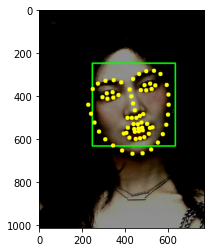

In [202]:
for point in list_points_front[0]:
    cv2.circle(img_show_front, point, 10, (0,255,255), -1)
    # 이미지위에 크기가 2이고 0-255 색으로 내부가 채워진(-1) 원을 그림
    
img_show_rgb_front = cv2.cvtColor(img_show_front, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb_front)
plt.show()

* 얼굴에 스티커 붙이기

In [203]:
refined_x_f, refined_y_f, img_sticker_f = attach_sticker(rects_front, list_points_front)

(444, 466)
(x,y) : (444,273)
(w,h) : (386,386)
(386, 386, 3)
(x,y) : (251,273)
(x,y) : (251,273)


In [204]:
sticker_area_front = img_show_front[refined_y_f:refined_y_f+img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]]
# 고양이 수염 이미지에서 사용할 부분은 0이 아닌 색이 있는 부분을 사용합니다.
# 고양이 수염 이미지에서 0이 나오는 부분은 흰색이라는 뜻, 즉 이미지가 없다는 소리임.
# sticker_area는 원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지입니다.
# 즉, 고양이 수염 이미지에서 고양이 수염 이미지가 없는 부분은 원본 이미지에서 미리 잘라놓은 sticker_area(스티커 적용할 부분 만큼 원본 이미지에서 자른 이미지)를 적용하고,
# 나머지 부분은 스티커로 채워주면 됨
# np.where는 조건에 해당하는 인덱스만 찾아서 값을 적용하는 방법이다.
# 아래 코드에서는 img_sticker가 0일 경우(고양이 수염 이미지에서 고양이 수염 부분 제외한 나머지 이미지)에는 sticker_area(원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지)를 적용하고,
# 나머지 부분은 img_sticker(고양이 수염 이미지)를 적용한다.
img_show_front[refined_y_f:refined_y_f+img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]] = \
    np.where(img_sticker_f==0,sticker_area_front,img_sticker_f).astype(np.uint8)

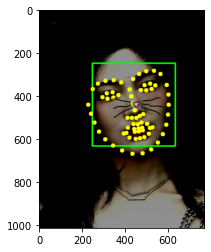

In [205]:
# 고양이 수염 이미지를 적용한 이미지를 보여준다.
# img_show에 고양이 수염 이미지를 덧붙인 이미지가 나오게 된다.)
plt.imshow(cv2.cvtColor(img_show_front, cv2.COLOR_BGR2RGB))
plt.show()

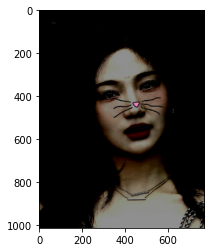

In [206]:
# 고양이 수염 이미지
sticker_area_front = img_bgr_front[refined_y_f:refined_y_f +img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]]
img_bgr_front[refined_y_f:refined_y_f +img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]] = \
    np.where(img_sticker_f==0,sticker_area_front,img_sticker_f).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr_front, cv2.COLOR_BGR2RGB)) # rgb만 적용해놓은 원본 이미지에 고양이 수염 이미지를 덮어 씌운 이미지가 나오게 된다.
plt.show()

### 밝은 빛

In [207]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/ningning_bright_pic.png' # 본인 이미지가 있는 경로를 가지고 온다.
img_bgr_front, img_show_front, img_rgb_front = get_pic_arr(my_image_path)

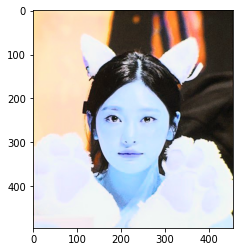

In [208]:
plt.imshow(img_bgr_front) # 이미지를 출력하기 위해 출력할 이미지를 올려준다. (실제 출력은 하지 않음)
plt.show() # 이미지를 출력해준다. (실제 출력)

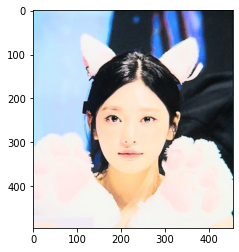

In [209]:
plt.imshow(img_rgb_front) # 이미지 실제 출력하기 위해 이미지를 올려줌 (원하는 사이즈의 픽셀을 원하는 색으로 채워서 만든 그림이라고 합니다.)
plt.show() # 이미지 실제 출력

* 얼굴 사각형 만들기

In [210]:
rects_front = make_rects(img_rgb_front)

rectangles[[(139, 201) (324, 387)]]
left: 139, top: 201, right: 324, bottom: 387


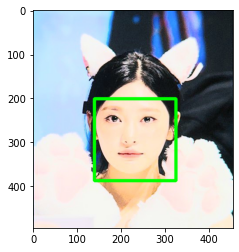

In [211]:
print(rects_front)
for rect in rects_front:
    l = rect.left() # left
    t = rect.top() # top
    r = rect.right() # right
    b = rect.bottom() # bottom
    print(f'left: {l}, top: {t}, right: {r}, bottom: {b}')
    
    cv2.rectangle(img_show_front, (l,t),(r,b),(0,255,0), 5, lineType = cv2.LINE_AA)

img_show_rgb_front = cv2.cvtColor(img_show_front, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb_front)
plt.show()

* 얼굴 이목구비 점 생성

In [212]:
list_points_front = make_points(rects_front, img_rgb_front)

68


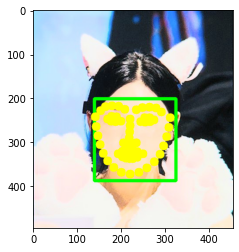

In [213]:
for point in list_points_front[0]:
    cv2.circle(img_show_front, point, 10, (0,255,255), -1)
    # 이미지위에 크기가 2이고 0-255 색으로 내부가 채워진(-1) 원을 그림
    
img_show_rgb_front = cv2.cvtColor(img_show_front, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb_front)
plt.show()

* 얼굴에 스티커 붙이기

In [214]:
refined_x_f, refined_y_f, img_sticker_f = attach_sticker(rects_front, list_points_front)

(218, 290)
(x,y) : (218,197)
(w,h) : (186,186)
(186, 186, 3)
(x,y) : (125,197)
(x,y) : (125,197)


In [215]:
sticker_area_front = img_show_front[refined_y_f:refined_y_f+img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]]
# 고양이 수염 이미지에서 사용할 부분은 0이 아닌 색이 있는 부분을 사용합니다.
# 고양이 수염 이미지에서 0이 나오는 부분은 흰색이라는 뜻, 즉 이미지가 없다는 소리임.
# sticker_area는 원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지입니다.
# 즉, 고양이 수염 이미지에서 고양이 수염 이미지가 없는 부분은 원본 이미지에서 미리 잘라놓은 sticker_area(스티커 적용할 부분 만큼 원본 이미지에서 자른 이미지)를 적용하고,
# 나머지 부분은 스티커로 채워주면 됨
# np.where는 조건에 해당하는 인덱스만 찾아서 값을 적용하는 방법이다.
# 아래 코드에서는 img_sticker가 0일 경우(고양이 수염 이미지에서 고양이 수염 부분 제외한 나머지 이미지)에는 sticker_area(원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지)를 적용하고,
# 나머지 부분은 img_sticker(고양이 수염 이미지)를 적용한다.
img_show_front[refined_y_f:refined_y_f+img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]] = \
    np.where(img_sticker_f==0,sticker_area_front,img_sticker_f).astype(np.uint8)

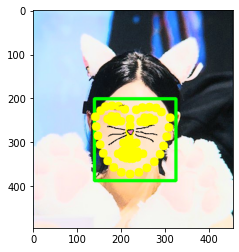

In [216]:
# 고양이 수염 이미지를 적용한 이미지를 보여준다.
# img_show에 고양이 수염 이미지를 덧붙인 이미지가 나오게 된다.)
plt.imshow(cv2.cvtColor(img_show_front, cv2.COLOR_BGR2RGB))
plt.show()

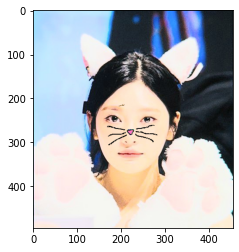

In [217]:
# 고양이 수염 이미지
sticker_area_front = img_bgr_front[refined_y_f:refined_y_f +img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]]
img_bgr_front[refined_y_f:refined_y_f +img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]] = \
    np.where(img_sticker_f==0,sticker_area_front,img_sticker_f).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr_front, cv2.COLOR_BGR2RGB)) # rgb만 적용해놓은 원본 이미지에 고양이 수염 이미지를 덮어 씌운 이미지가 나오게 된다.
plt.show()

* 위에 사용한 정면사진을 밝게 만든 경우

In [218]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/ningning_front_light.png' # 본인 이미지가 있는 경로를 가지고 온다.
img_bgr_front, img_show_front, img_rgb_front = get_pic_arr(my_image_path)

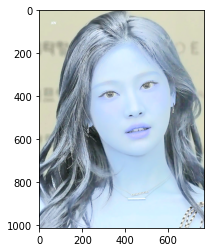

In [219]:
plt.imshow(img_bgr_front) # 이미지를 출력하기 위해 출력할 이미지를 올려준다. (실제 출력은 하지 않음)
plt.show() # 이미지를 출력해준다. (실제 출력)

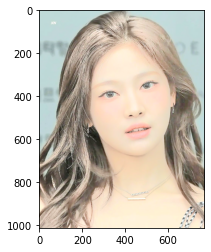

In [220]:
plt.imshow(img_rgb_front) # 이미지 실제 출력하기 위해 이미지를 올려줌 (원하는 사이즈의 픽셀을 원하는 색으로 채워서 만든 그림이라고 합니다.)
plt.show() # 이미지 실제 출력

* 얼굴 사각형 만들기

In [221]:
rects_front = make_rects(img_rgb_front)

rectangles[[(247, 247) (632, 632)]]
left: 247, top: 247, right: 632, bottom: 632


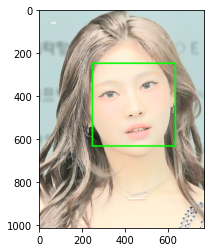

In [222]:
print(rects_front)
for rect in rects_front:
    l = rect.left() # left
    t = rect.top() # top
    r = rect.right() # right
    b = rect.bottom() # bottom
    print(f'left: {l}, top: {t}, right: {r}, bottom: {b}')
    
    cv2.rectangle(img_show_front, (l,t),(r,b),(0,255,0), 5, lineType = cv2.LINE_AA)

img_show_rgb_front = cv2.cvtColor(img_show_front, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb_front)
plt.show()

* 얼굴 이목구비 점 생성

In [223]:
list_points_front = make_points(rects_front, img_rgb_front)

68


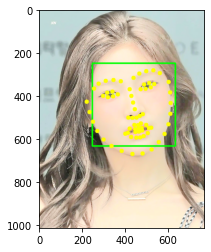

In [224]:
for point in list_points_front[0]:
    cv2.circle(img_show_front, point, 10, (0,255,255), -1)
    # 이미지위에 크기가 2이고 0-255 색으로 내부가 채워진(-1) 원을 그림
    
img_show_rgb_front = cv2.cvtColor(img_show_front, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb_front)
plt.show()

* 얼굴에 스티커 붙이기

In [225]:
refined_x_f, refined_y_f, img_sticker_f = attach_sticker(rects_front, list_points_front)

(444, 461)
(x,y) : (444,268)
(w,h) : (386,386)
(386, 386, 3)
(x,y) : (251,268)
(x,y) : (251,268)


In [226]:
sticker_area_front = img_show_front[refined_y_f:refined_y_f+img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]]
# 고양이 수염 이미지에서 사용할 부분은 0이 아닌 색이 있는 부분을 사용합니다.
# 고양이 수염 이미지에서 0이 나오는 부분은 흰색이라는 뜻, 즉 이미지가 없다는 소리임.
# sticker_area는 원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지입니다.
# 즉, 고양이 수염 이미지에서 고양이 수염 이미지가 없는 부분은 원본 이미지에서 미리 잘라놓은 sticker_area(스티커 적용할 부분 만큼 원본 이미지에서 자른 이미지)를 적용하고,
# 나머지 부분은 스티커로 채워주면 됨
# np.where는 조건에 해당하는 인덱스만 찾아서 값을 적용하는 방법이다.
# 아래 코드에서는 img_sticker가 0일 경우(고양이 수염 이미지에서 고양이 수염 부분 제외한 나머지 이미지)에는 sticker_area(원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지)를 적용하고,
# 나머지 부분은 img_sticker(고양이 수염 이미지)를 적용한다.
img_show_front[refined_y_f:refined_y_f+img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]] = \
    np.where(img_sticker_f==0,sticker_area_front,img_sticker_f).astype(np.uint8)

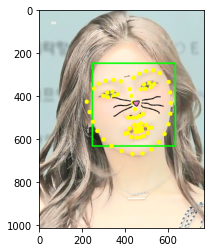

In [227]:
# 고양이 수염 이미지를 적용한 이미지를 보여준다.
# img_show에 고양이 수염 이미지를 덧붙인 이미지가 나오게 된다.)
plt.imshow(cv2.cvtColor(img_show_front, cv2.COLOR_BGR2RGB))
plt.show()

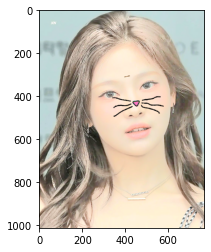

In [228]:
# 고양이 수염 이미지
sticker_area_front = img_bgr_front[refined_y_f:refined_y_f +img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]]
img_bgr_front[refined_y_f:refined_y_f +img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]] = \
    np.where(img_sticker_f==0,sticker_area_front,img_sticker_f).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr_front, cv2.COLOR_BGR2RGB)) # rgb만 적용해놓은 원본 이미지에 고양이 수염 이미지를 덮어 씌운 이미지가 나오게 된다.
plt.show()

### 누운 모습

In [328]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/ningning_lying_down.png' # 본인 이미지가 있는 경로를 가지고 온다.
img_bgr_front, img_show_front, img_rgb_front = get_pic_arr(my_image_path)

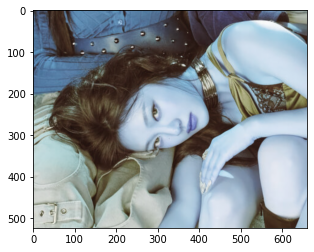

In [329]:
plt.imshow(img_bgr_front) # 이미지를 출력하기 위해 출력할 이미지를 올려준다. (실제 출력은 하지 않음)
plt.show() # 이미지를 출력해준다. (실제 출력)

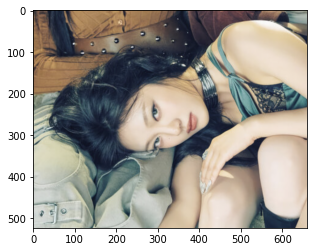

In [330]:
plt.imshow(img_rgb_front) # 이미지 실제 출력하기 위해 이미지를 올려줌 (원하는 사이즈의 픽셀을 원하는 색으로 채워서 만든 그림이라고 합니다.)
plt.show() # 이미지 실제 출력

* 얼굴 사각형 만들기

In [331]:
rects_front = make_rects(img_rgb_front)

rectangles[]


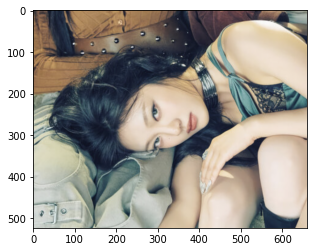

In [332]:
print(rects_front)
for rect in rects_front:
    l = rect.left() # left
    t = rect.top() # top
    r = rect.right() # right
    b = rect.bottom() # bottom
    print(f'left: {l}, top: {t}, right: {r}, bottom: {b}')
    
    cv2.rectangle(img_show_front, (l,t),(r,b),(0,255,0), 5, lineType = cv2.LINE_AA)

img_show_rgb_front = cv2.cvtColor(img_show_front, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb_front)
plt.show()

* 얼굴 이목구비 점 생성

In [339]:
list_points_front_1 = make_points(rects_front, img_rgb_front)

IndexError: list index out of range

In [337]:
len(list_points_front_1)

1

In [340]:
for point in list_points_front_1[0]:
    cv2.circle(img_show_front, point, 10, (0,255,255), -1)
    # 이미지위에 크기가 2이고 0-255 색으로 내부가 채워진(-1) 원을 그림
    
img_show_rgb_front = cv2.cvtColor(img_show_front, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb_front)
plt.show()

NameError: name 'list_points_front_1' is not defined

* 얼굴에 스티커 붙이기

In [341]:
refined_x_f, refined_y_f, img_sticker_f = attach_sticker(rects_front, list_points_front_1)

NameError: name 'list_points_front_1' is not defined

In [342]:
sticker_area_front = img_show_front[refined_y_f:refined_y_f+img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]]
# 고양이 수염 이미지에서 사용할 부분은 0이 아닌 색이 있는 부분을 사용합니다.
# 고양이 수염 이미지에서 0이 나오는 부분은 흰색이라는 뜻, 즉 이미지가 없다는 소리임.
# sticker_area는 원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지입니다.
# 즉, 고양이 수염 이미지에서 고양이 수염 이미지가 없는 부분은 원본 이미지에서 미리 잘라놓은 sticker_area(스티커 적용할 부분 만큼 원본 이미지에서 자른 이미지)를 적용하고,
# 나머지 부분은 스티커로 채워주면 됨
# np.where는 조건에 해당하는 인덱스만 찾아서 값을 적용하는 방법이다.
# 아래 코드에서는 img_sticker가 0일 경우(고양이 수염 이미지에서 고양이 수염 부분 제외한 나머지 이미지)에는 sticker_area(원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지)를 적용하고,
# 나머지 부분은 img_sticker(고양이 수염 이미지)를 적용한다.
img_show_front[refined_y_f:refined_y_f+img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]] = \
    np.where(img_sticker_f==0,sticker_area_front,img_sticker_f).astype(np.uint8)

ValueError: operands could not be broadcast together with shapes (156,156,3) (153,156,3) (156,156,3) 

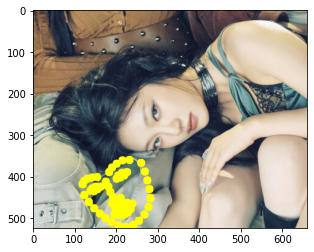

In [343]:
# 고양이 수염 이미지를 적용한 이미지를 보여준다.
# img_show에 고양이 수염 이미지를 덧붙인 이미지가 나오게 된다.)
plt.imshow(cv2.cvtColor(img_show_front, cv2.COLOR_BGR2RGB))
plt.show()

In [344]:
# 고양이 수염 이미지
sticker_area_front = img_bgr_front[refined_y_f:refined_y_f +img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]]
img_bgr_front[refined_y_f:refined_y_f +img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]] = \
    np.where(img_sticker_f==0,sticker_area_front,img_sticker_f).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr_front, cv2.COLOR_BGR2RGB)) # rgb만 적용해놓은 원본 이미지에 고양이 수염 이미지를 덮어 씌운 이미지가 나오게 된다.
plt.show()

ValueError: operands could not be broadcast together with shapes (156,156,3) (153,156,3) (156,156,3) 

누운 모습을 실험하니 아예 얼굴을 탐지하지 못 했다. 이 사진만 그런 것일까 싶어서 다른 누운 사진으로도 실험해보았다.

* 다른 누운 모습

In [345]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/ningning_sleeping.png' # 본인 이미지가 있는 경로를 가지고 온다.
img_bgr_front, img_show_front, img_rgb_front = get_pic_arr(my_image_path)

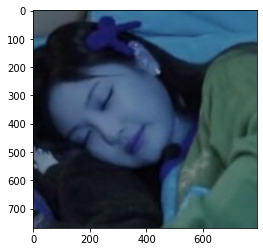

In [346]:
plt.imshow(img_bgr_front) # 이미지를 출력하기 위해 출력할 이미지를 올려준다. (실제 출력은 하지 않음)
plt.show() # 이미지를 출력해준다. (실제 출력)

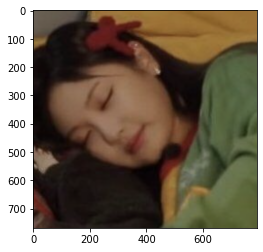

In [347]:
plt.imshow(img_rgb_front) # 이미지 실제 출력하기 위해 이미지를 올려줌 (원하는 사이즈의 픽셀을 원하는 색으로 채워서 만든 그림이라고 합니다.)
plt.show() # 이미지 실제 출력

* 얼굴 사각형 만들기

In [348]:
rects_front = make_rects(img_rgb_front)

rectangles[]


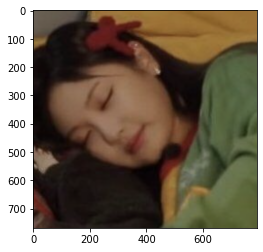

In [349]:
print(rects_front)
for rect in rects_front:
    l = rect.left() # left
    t = rect.top() # top
    r = rect.right() # right
    b = rect.bottom() # bottom
    print(f'left: {l}, top: {t}, right: {r}, bottom: {b}')
    
    cv2.rectangle(img_show_front, (l,t),(r,b),(0,255,0), 5, lineType = cv2.LINE_AA)

img_show_rgb_front = cv2.cvtColor(img_show_front, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb_front)
plt.show()

* 얼굴 이목구비 점 생성

In [352]:
list_points_front_1 = make_points(rects_front, img_rgb_front)

IndexError: list index out of range

In [353]:
for point in list_points_front_1[0]:
    cv2.circle(img_show_front, point, 10, (0,255,255), -1)
    # 이미지위에 크기가 2이고 0-255 색으로 내부가 채워진(-1) 원을 그림
    
img_show_rgb_front = cv2.cvtColor(img_show_front, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb_front)
plt.show()

NameError: name 'list_points_front_1' is not defined

* 얼굴에 스티커 붙이기

In [354]:
refined_x_f, refined_y_f, img_sticker_f = attach_sticker(rects_front, list_points_front_1)

NameError: name 'list_points_front_1' is not defined

In [355]:
sticker_area_front = img_show_front[refined_y_f:refined_y_f+img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]]
# 고양이 수염 이미지에서 사용할 부분은 0이 아닌 색이 있는 부분을 사용합니다.
# 고양이 수염 이미지에서 0이 나오는 부분은 흰색이라는 뜻, 즉 이미지가 없다는 소리임.
# sticker_area는 원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지입니다.
# 즉, 고양이 수염 이미지에서 고양이 수염 이미지가 없는 부분은 원본 이미지에서 미리 잘라놓은 sticker_area(스티커 적용할 부분 만큼 원본 이미지에서 자른 이미지)를 적용하고,
# 나머지 부분은 스티커로 채워주면 됨
# np.where는 조건에 해당하는 인덱스만 찾아서 값을 적용하는 방법이다.
# 아래 코드에서는 img_sticker가 0일 경우(고양이 수염 이미지에서 고양이 수염 부분 제외한 나머지 이미지)에는 sticker_area(원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지)를 적용하고,
# 나머지 부분은 img_sticker(고양이 수염 이미지)를 적용한다.
img_show_front[refined_y_f:refined_y_f+img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]] = \
    np.where(img_sticker_f==0,sticker_area_front,img_sticker_f).astype(np.uint8)

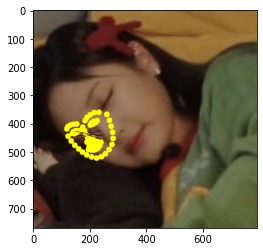

In [356]:
# 고양이 수염 이미지를 적용한 이미지를 보여준다.
# img_show에 고양이 수염 이미지를 덧붙인 이미지가 나오게 된다.)
plt.imshow(cv2.cvtColor(img_show_front, cv2.COLOR_BGR2RGB))
plt.show()

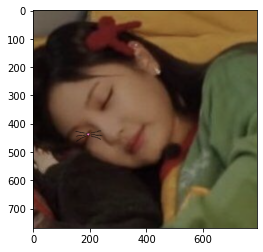

In [357]:
# 고양이 수염 이미지
sticker_area_front = img_bgr_front[refined_y_f:refined_y_f +img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]]
img_bgr_front[refined_y_f:refined_y_f +img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]] = \
    np.where(img_sticker_f==0,sticker_area_front,img_sticker_f).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr_front, cv2.COLOR_BGR2RGB)) # rgb만 적용해놓은 원본 이미지에 고양이 수염 이미지를 덮어 씌운 이미지가 나오게 된다.
plt.show()

다른 누워있는 사진으로 실험해본 결과도 똑같다. 누워있는 사진은 얼굴을 탐지 못하는 것 같다.

### 얼굴에 아이템이 있는 경우

In [268]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/ningning_with_item_on_her_face.png' # 본인 이미지가 있는 경로를 가지고 온다.
img_bgr_front, img_show_front, img_rgb_front = get_pic_arr(my_image_path)

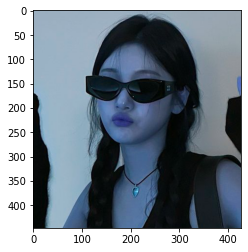

In [269]:
plt.imshow(img_bgr_front) # 이미지를 출력하기 위해 출력할 이미지를 올려준다. (실제 출력은 하지 않음)
plt.show() # 이미지를 출력해준다. (실제 출력)

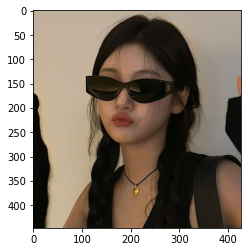

In [270]:
plt.imshow(img_rgb_front) # 이미지 실제 출력하기 위해 이미지를 올려줌 (원하는 사이즈의 픽셀을 원하는 색으로 채워서 만든 그림이라고 합니다.)
plt.show() # 이미지 실제 출력

* 얼굴 사각형 만들기

In [271]:
rects_front = make_rects(img_rgb_front)

rectangles[[(124, 139) (253, 268)]]
left: 124, top: 139, right: 253, bottom: 268


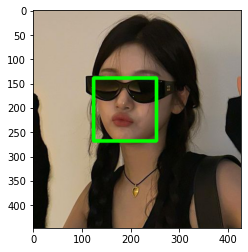

In [272]:
print(rects_front)
for rect in rects_front:
    l = rect.left() # left
    t = rect.top() # top
    r = rect.right() # right
    b = rect.bottom() # bottom
    print(f'left: {l}, top: {t}, right: {r}, bottom: {b}')
    
    cv2.rectangle(img_show_front, (l,t),(r,b),(0,255,0), 5, lineType = cv2.LINE_AA)

img_show_rgb_front = cv2.cvtColor(img_show_front, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb_front)
plt.show()

* 얼굴 이목구비 점 생성

In [274]:
list_points_front = make_points(rects_front, img_rgb_front)

68


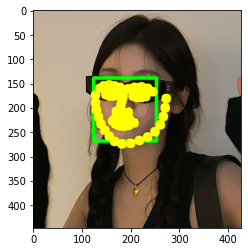

In [275]:
for point in list_points_front[0]:
    cv2.circle(img_show_front, point, 10, (0,255,255), -1)
    # 이미지위에 크기가 2이고 0-255 색으로 내부가 채워진(-1) 원을 그림
    
img_show_rgb_front = cv2.cvtColor(img_show_front, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb_front)
plt.show()

* 얼굴에 스티커 붙이기

In [276]:
refined_x_f, refined_y_f, img_sticker_f = attach_sticker(rects_front, list_points_front)

(180, 194)
(x,y) : (180,129)
(w,h) : (130,130)
(130, 130, 3)
(x,y) : (115,129)
(x,y) : (115,129)


In [277]:
sticker_area_front = img_show_front[refined_y_f:refined_y_f+img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]]
# 고양이 수염 이미지에서 사용할 부분은 0이 아닌 색이 있는 부분을 사용합니다.
# 고양이 수염 이미지에서 0이 나오는 부분은 흰색이라는 뜻, 즉 이미지가 없다는 소리임.
# sticker_area는 원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지입니다.
# 즉, 고양이 수염 이미지에서 고양이 수염 이미지가 없는 부분은 원본 이미지에서 미리 잘라놓은 sticker_area(스티커 적용할 부분 만큼 원본 이미지에서 자른 이미지)를 적용하고,
# 나머지 부분은 스티커로 채워주면 됨
# np.where는 조건에 해당하는 인덱스만 찾아서 값을 적용하는 방법이다.
# 아래 코드에서는 img_sticker가 0일 경우(고양이 수염 이미지에서 고양이 수염 부분 제외한 나머지 이미지)에는 sticker_area(원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지)를 적용하고,
# 나머지 부분은 img_sticker(고양이 수염 이미지)를 적용한다.
img_show_front[refined_y_f:refined_y_f+img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]] = \
    np.where(img_sticker_f==0,sticker_area_front,img_sticker_f).astype(np.uint8)

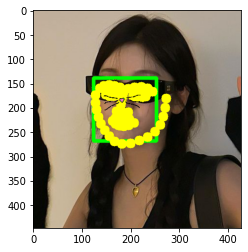

In [278]:
# 고양이 수염 이미지를 적용한 이미지를 보여준다.
# img_show에 고양이 수염 이미지를 덧붙인 이미지가 나오게 된다.)
plt.imshow(cv2.cvtColor(img_show_front, cv2.COLOR_BGR2RGB))
plt.show()

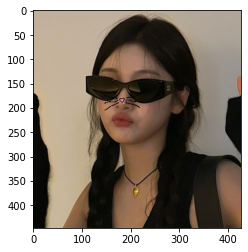

In [279]:
# 고양이 수염 이미지
sticker_area_front = img_bgr_front[refined_y_f:refined_y_f +img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]]
img_bgr_front[refined_y_f:refined_y_f +img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]] = \
    np.where(img_sticker_f==0,sticker_area_front,img_sticker_f).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr_front, cv2.COLOR_BGR2RGB)) # rgb만 적용해놓은 원본 이미지에 고양이 수염 이미지를 덮어 씌운 이미지가 나오게 된다.
plt.show()

### 얼굴이 머리카락으로 옆이 가려져있는 경우

In [280]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/ningning_hair_covered_her_face.png' # 본인 이미지가 있는 경로를 가지고 온다.
img_bgr_front, img_show_front, img_rgb_front = get_pic_arr(my_image_path)

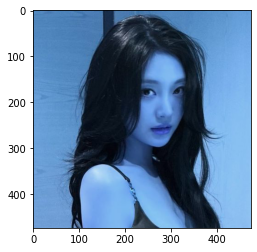

In [281]:
plt.imshow(img_bgr_front) # 이미지를 출력하기 위해 출력할 이미지를 올려준다. (실제 출력은 하지 않음)
plt.show() # 이미지를 출력해준다. (실제 출력)

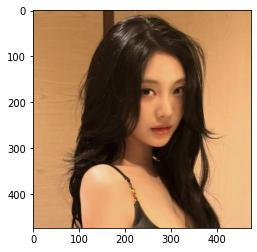

In [282]:
plt.imshow(img_rgb_front) # 이미지 실제 출력하기 위해 이미지를 올려줌 (원하는 사이즈의 픽셀을 원하는 색으로 채워서 만든 그림이라고 합니다.)
plt.show() # 이미지 실제 출력

* 얼굴 사각형 만들기

In [283]:
rects_front = make_rects(img_rgb_front)

rectangles[[(201, 133) (356, 288)]]
left: 201, top: 133, right: 356, bottom: 288


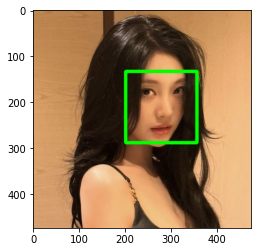

In [284]:
print(rects_front)
for rect in rects_front:
    l = rect.left() # left
    t = rect.top() # top
    r = rect.right() # right
    b = rect.bottom() # bottom
    print(f'left: {l}, top: {t}, right: {r}, bottom: {b}')
    
    cv2.rectangle(img_show_front, (l,t),(r,b),(0,255,0), 5, lineType = cv2.LINE_AA)

img_show_rgb_front = cv2.cvtColor(img_show_front, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb_front)
plt.show()

* 얼굴 이목구비 점 생성

In [285]:
list_points_front = make_points(rects_front, img_rgb_front)

68


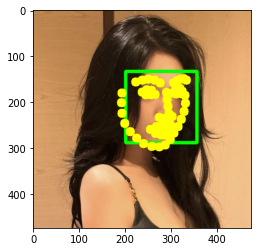

In [286]:
for point in list_points_front[0]:
    cv2.circle(img_show_front, point, 10, (0,255,255), -1)
    # 이미지위에 크기가 2이고 0-255 색으로 내부가 채워진(-1) 원을 그림
    
img_show_rgb_front = cv2.cvtColor(img_show_front, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb_front)
plt.show()

* 얼굴에 스티커 붙이기

In [287]:
refined_x_f, refined_y_f, img_sticker_f = attach_sticker(rects_front, list_points_front)

(295, 225)
(x,y) : (295,147)
(w,h) : (156,156)
(156, 156, 3)
(x,y) : (217,147)
(x,y) : (217,147)


In [288]:
sticker_area_front = img_show_front[refined_y_f:refined_y_f+img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]]
# 고양이 수염 이미지에서 사용할 부분은 0이 아닌 색이 있는 부분을 사용합니다.
# 고양이 수염 이미지에서 0이 나오는 부분은 흰색이라는 뜻, 즉 이미지가 없다는 소리임.
# sticker_area는 원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지입니다.
# 즉, 고양이 수염 이미지에서 고양이 수염 이미지가 없는 부분은 원본 이미지에서 미리 잘라놓은 sticker_area(스티커 적용할 부분 만큼 원본 이미지에서 자른 이미지)를 적용하고,
# 나머지 부분은 스티커로 채워주면 됨
# np.where는 조건에 해당하는 인덱스만 찾아서 값을 적용하는 방법이다.
# 아래 코드에서는 img_sticker가 0일 경우(고양이 수염 이미지에서 고양이 수염 부분 제외한 나머지 이미지)에는 sticker_area(원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지)를 적용하고,
# 나머지 부분은 img_sticker(고양이 수염 이미지)를 적용한다.
img_show_front[refined_y_f:refined_y_f+img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]] = \
    np.where(img_sticker_f==0,sticker_area_front,img_sticker_f).astype(np.uint8)

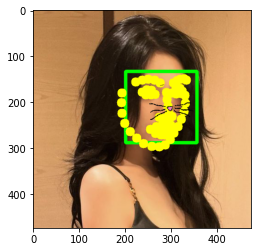

In [289]:
# 고양이 수염 이미지를 적용한 이미지를 보여준다.
# img_show에 고양이 수염 이미지를 덧붙인 이미지가 나오게 된다.)
plt.imshow(cv2.cvtColor(img_show_front, cv2.COLOR_BGR2RGB))
plt.show()

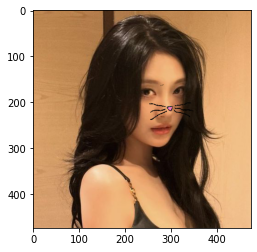

In [290]:
# 고양이 수염 이미지
sticker_area_front = img_bgr_front[refined_y_f:refined_y_f +img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]]
img_bgr_front[refined_y_f:refined_y_f +img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]] = \
    np.where(img_sticker_f==0,sticker_area_front,img_sticker_f).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr_front, cv2.COLOR_BGR2RGB)) # rgb만 적용해놓은 원본 이미지에 고양이 수염 이미지를 덮어 씌운 이미지가 나오게 된다.
plt.show()

### 멀리 있는 경우

In [291]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/ningning_airport_wholebody.png' # 본인 이미지가 있는 경로를 가지고 온다.
img_bgr_front, img_show_front, img_rgb_front = get_pic_arr(my_image_path)

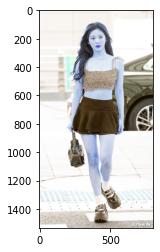

In [292]:
plt.imshow(img_bgr_front) # 이미지를 출력하기 위해 출력할 이미지를 올려준다. (실제 출력은 하지 않음)
plt.show() # 이미지를 출력해준다. (실제 출력)

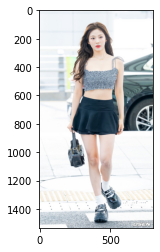

In [293]:
plt.imshow(img_rgb_front) # 이미지 실제 출력하기 위해 이미지를 올려줌 (원하는 사이즈의 픽셀을 원하는 색으로 채워서 만든 그림이라고 합니다.)
plt.show() # 이미지 실제 출력

* 얼굴 사각형 만들기

In [294]:
rects_front = make_rects(img_rgb_front)

rectangles[[(339, 168) (468, 297)]]
left: 339, top: 168, right: 468, bottom: 297


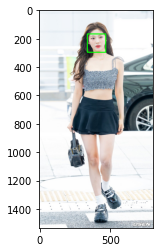

In [295]:
print(rects_front)
for rect in rects_front:
    l = rect.left() # left
    t = rect.top() # top
    r = rect.right() # right
    b = rect.bottom() # bottom
    print(f'left: {l}, top: {t}, right: {r}, bottom: {b}')
    
    cv2.rectangle(img_show_front, (l,t),(r,b),(0,255,0), 5, lineType = cv2.LINE_AA)

img_show_rgb_front = cv2.cvtColor(img_show_front, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb_front)
plt.show()

* 얼굴 이목구비 점 생성

In [296]:
list_points_front = make_points(rects_front, img_rgb_front)

68


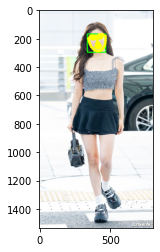

In [297]:
for point in list_points_front[0]:
    cv2.circle(img_show_front, point, 10, (0,255,255), -1)
    # 이미지위에 크기가 2이고 0-255 색으로 내부가 채워진(-1) 원을 그림
    
img_show_rgb_front = cv2.cvtColor(img_show_front, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb_front)
plt.show()

* 얼굴에 스티커 붙이기

In [298]:
refined_x_f, refined_y_f, img_sticker_f = attach_sticker(rects_front, list_points_front)

(411, 225)
(x,y) : (411,160)
(w,h) : (130,130)
(130, 130, 3)
(x,y) : (346,160)
(x,y) : (346,160)


In [299]:
sticker_area_front = img_show_front[refined_y_f:refined_y_f+img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]]
# 고양이 수염 이미지에서 사용할 부분은 0이 아닌 색이 있는 부분을 사용합니다.
# 고양이 수염 이미지에서 0이 나오는 부분은 흰색이라는 뜻, 즉 이미지가 없다는 소리임.
# sticker_area는 원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지입니다.
# 즉, 고양이 수염 이미지에서 고양이 수염 이미지가 없는 부분은 원본 이미지에서 미리 잘라놓은 sticker_area(스티커 적용할 부분 만큼 원본 이미지에서 자른 이미지)를 적용하고,
# 나머지 부분은 스티커로 채워주면 됨
# np.where는 조건에 해당하는 인덱스만 찾아서 값을 적용하는 방법이다.
# 아래 코드에서는 img_sticker가 0일 경우(고양이 수염 이미지에서 고양이 수염 부분 제외한 나머지 이미지)에는 sticker_area(원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지)를 적용하고,
# 나머지 부분은 img_sticker(고양이 수염 이미지)를 적용한다.
img_show_front[refined_y_f:refined_y_f+img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]] = \
    np.where(img_sticker_f==0,sticker_area_front,img_sticker_f).astype(np.uint8)

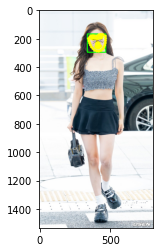

In [300]:
# 고양이 수염 이미지를 적용한 이미지를 보여준다.
# img_show에 고양이 수염 이미지를 덧붙인 이미지가 나오게 된다.)
plt.imshow(cv2.cvtColor(img_show_front, cv2.COLOR_BGR2RGB))
plt.show()

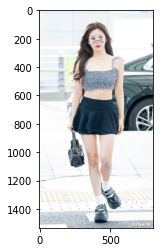

In [301]:
# 고양이 수염 이미지
sticker_area_front = img_bgr_front[refined_y_f:refined_y_f +img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]]
img_bgr_front[refined_y_f:refined_y_f +img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]] = \
    np.where(img_sticker_f==0,sticker_area_front,img_sticker_f).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr_front, cv2.COLOR_BGR2RGB)) # rgb만 적용해놓은 원본 이미지에 고양이 수염 이미지를 덮어 씌운 이미지가 나오게 된다.
plt.show()

### 얼굴이 너무 가까이에 있는 경우

In [303]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/ningning_enlarged_face.png' # 본인 이미지가 있는 경로를 가지고 온다.
img_bgr_front, img_show_front, img_rgb_front = get_pic_arr(my_image_path)

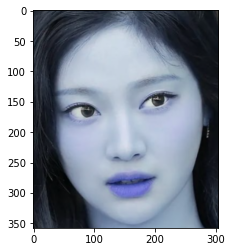

In [304]:
plt.imshow(img_bgr_front) # 이미지를 출력하기 위해 출력할 이미지를 올려준다. (실제 출력은 하지 않음)
plt.show() # 이미지를 출력해준다. (실제 출력)

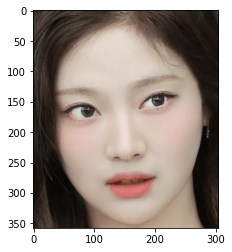

In [305]:
plt.imshow(img_rgb_front) # 이미지 실제 출력하기 위해 이미지를 올려줌 (원하는 사이즈의 픽셀을 원하는 색으로 채워서 만든 그림이라고 합니다.)
plt.show() # 이미지 실제 출력

* 얼굴 사각형 만들기

In [306]:
rects_front = make_rects(img_rgb_front)

rectangles[[(22, 82) (290, 350)]]
left: 22, top: 82, right: 290, bottom: 350


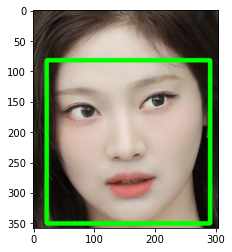

In [307]:
print(rects_front)
for rect in rects_front:
    l = rect.left() # left
    t = rect.top() # top
    r = rect.right() # right
    b = rect.bottom() # bottom
    print(f'left: {l}, top: {t}, right: {r}, bottom: {b}')
    
    cv2.rectangle(img_show_front, (l,t),(r,b),(0,255,0), 5, lineType = cv2.LINE_AA)

img_show_rgb_front = cv2.cvtColor(img_show_front, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb_front)
plt.show()

* 얼굴 이목구비 점 생성

In [308]:
list_points_front = make_points(rects_front, img_rgb_front)

68


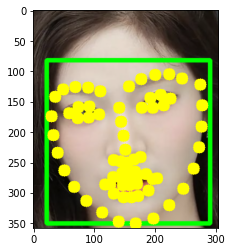

In [309]:
for point in list_points_front[0]:
    cv2.circle(img_show_front, point, 10, (0,255,255), -1)
    # 이미지위에 크기가 2이고 0-255 색으로 내부가 채워진(-1) 원을 그림
    
img_show_rgb_front = cv2.cvtColor(img_show_front, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb_front)
plt.show()

* 얼굴에 스티커 붙이기

In [313]:
refined_x_f, refined_y_f, img_sticker_f = attach_sticker(rects_front, list_points_front)

(151, 229)
(x,y) : (151,95)
(w,h) : (269,269)
(269, 269, 3)
(x,y) : (17,95)
(x,y) : (17,95)


In [314]:
sticker_area_front = img_show_front[refined_y_f:refined_y_f+img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]]
# 고양이 수염 이미지에서 사용할 부분은 0이 아닌 색이 있는 부분을 사용합니다.
# 고양이 수염 이미지에서 0이 나오는 부분은 흰색이라는 뜻, 즉 이미지가 없다는 소리임.
# sticker_area는 원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지입니다.
# 즉, 고양이 수염 이미지에서 고양이 수염 이미지가 없는 부분은 원본 이미지에서 미리 잘라놓은 sticker_area(스티커 적용할 부분 만큼 원본 이미지에서 자른 이미지)를 적용하고,
# 나머지 부분은 스티커로 채워주면 됨
# np.where는 조건에 해당하는 인덱스만 찾아서 값을 적용하는 방법이다.
# 아래 코드에서는 img_sticker가 0일 경우(고양이 수염 이미지에서 고양이 수염 부분 제외한 나머지 이미지)에는 sticker_area(원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지)를 적용하고,
# 나머지 부분은 img_sticker(고양이 수염 이미지)를 적용한다.
img_show_front[refined_y_f:refined_y_f+img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]] = \
    np.where(img_sticker_f==0,sticker_area_front,img_sticker_f).astype(np.uint8)

ValueError: operands could not be broadcast together with shapes (269,269,3) (263,269,3) (269,269,3) 

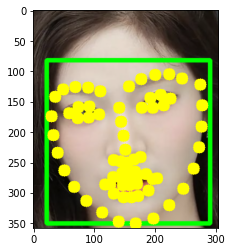

In [312]:
# 고양이 수염 이미지를 적용한 이미지를 보여준다.
# img_show에 고양이 수염 이미지를 덧붙인 이미지가 나오게 된다.)
plt.imshow(cv2.cvtColor(img_show_front, cv2.COLOR_BGR2RGB))
plt.show()

In [315]:
# 고양이 수염 이미지
sticker_area_front = img_bgr_front[refined_y_f:refined_y_f +img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]]
img_bgr_front[refined_y_f:refined_y_f +img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]] = \
    np.where(img_sticker_f==0,sticker_area_front,img_sticker_f).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr_front, cv2.COLOR_BGR2RGB)) # rgb만 적용해놓은 원본 이미지에 고양이 수염 이미지를 덮어 씌운 이미지가 나오게 된다.
plt.show()

ValueError: operands could not be broadcast together with shapes (269,269,3) (263,269,3) (269,269,3) 

### 검정이나 하얀 조명이 아닌 다른 색의 조명일 경우

In [316]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/ningning_with_different_color.png' # 본인 이미지가 있는 경로를 가지고 온다.
img_bgr_front, img_show_front, img_rgb_front = get_pic_arr(my_image_path)

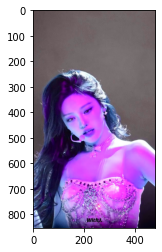

In [317]:
plt.imshow(img_bgr_front) # 이미지를 출력하기 위해 출력할 이미지를 올려준다. (실제 출력은 하지 않음)
plt.show() # 이미지를 출력해준다. (실제 출력)

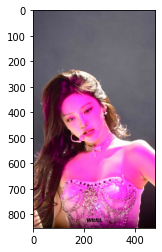

In [318]:
plt.imshow(img_rgb_front) # 이미지 실제 출력하기 위해 이미지를 올려줌 (원하는 사이즈의 픽셀을 원하는 색으로 채워서 만든 그림이라고 합니다.)
plt.show() # 이미지 실제 출력

* 얼굴 사각형 만들기

In [319]:
rects_front = make_rects(img_rgb_front)

rectangles[[(115, 356) (270, 511)]]
left: 115, top: 356, right: 270, bottom: 511


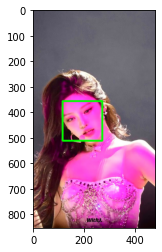

In [320]:
print(rects_front)
for rect in rects_front:
    l = rect.left() # left
    t = rect.top() # top
    r = rect.right() # right
    b = rect.bottom() # bottom
    print(f'left: {l}, top: {t}, right: {r}, bottom: {b}')
    
    cv2.rectangle(img_show_front, (l,t),(r,b),(0,255,0), 5, lineType = cv2.LINE_AA)

img_show_rgb_front = cv2.cvtColor(img_show_front, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb_front)
plt.show()

* 얼굴 이목구비 점 생성

In [321]:
list_points_front = make_points(rects_front, img_rgb_front)

68


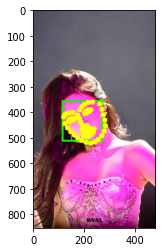

In [322]:
for point in list_points_front[0]:
    cv2.circle(img_show_front, point, 10, (0,255,255), -1)
    # 이미지위에 크기가 2이고 0-255 색으로 내부가 채워진(-1) 원을 그림
    
img_show_rgb_front = cv2.cvtColor(img_show_front, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb_front)
plt.show()

* 얼굴에 스티커 붙이기

In [323]:
refined_x_f, refined_y_f, img_sticker_f = attach_sticker(rects_front, list_points_front)

(192, 449)
(x,y) : (192,371)
(w,h) : (156,156)
(156, 156, 3)
(x,y) : (114,371)
(x,y) : (114,371)


In [324]:
sticker_area_front = img_show_front[refined_y_f:refined_y_f+img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]]
# 고양이 수염 이미지에서 사용할 부분은 0이 아닌 색이 있는 부분을 사용합니다.
# 고양이 수염 이미지에서 0이 나오는 부분은 흰색이라는 뜻, 즉 이미지가 없다는 소리임.
# sticker_area는 원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지입니다.
# 즉, 고양이 수염 이미지에서 고양이 수염 이미지가 없는 부분은 원본 이미지에서 미리 잘라놓은 sticker_area(스티커 적용할 부분 만큼 원본 이미지에서 자른 이미지)를 적용하고,
# 나머지 부분은 스티커로 채워주면 됨
# np.where는 조건에 해당하는 인덱스만 찾아서 값을 적용하는 방법이다.
# 아래 코드에서는 img_sticker가 0일 경우(고양이 수염 이미지에서 고양이 수염 부분 제외한 나머지 이미지)에는 sticker_area(원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지)를 적용하고,
# 나머지 부분은 img_sticker(고양이 수염 이미지)를 적용한다.
img_show_front[refined_y_f:refined_y_f+img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]] = \
    np.where(img_sticker_f==0,sticker_area_front,img_sticker_f).astype(np.uint8)

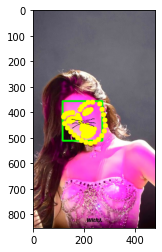

In [325]:
# 고양이 수염 이미지를 적용한 이미지를 보여준다.
# img_show에 고양이 수염 이미지를 덧붙인 이미지가 나오게 된다.)
plt.imshow(cv2.cvtColor(img_show_front, cv2.COLOR_BGR2RGB))
plt.show()

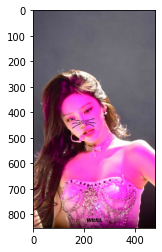

In [326]:
# 고양이 수염 이미지
sticker_area_front = img_bgr_front[refined_y_f:refined_y_f +img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]]
img_bgr_front[refined_y_f:refined_y_f +img_sticker_f.shape[0], refined_x_f:refined_x_f+img_sticker_f.shape[1]] = \
    np.where(img_sticker_f==0,sticker_area_front,img_sticker_f).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr_front, cv2.COLOR_BGR2RGB)) # rgb만 적용해놓은 원본 이미지에 고양이 수염 이미지를 덮어 씌운 이미지가 나오게 된다.
plt.show()

### 결과와 문제점
* 정면, 밝게 만든 사진, 어둡게 만든 사진, 다른 조명의 사진, 살짝 옆을 보는 모습 등 이목구비가 제대로 보이는 사진들은 스티커가 정상적인 위치에 부착되었다. 
* 하지만 고개를 갸우뚱한 모습이라면 수염이 거기에 맞게 rotation이 되어 붙여지는 것이 아니고 같은 위치에 그대로 붙여진다.
* 완전히 옆모습을 보고있는 경우에는 이목구비가 제대로 보이지 않다보니 다른 부분을 눈코입으로 인식하여 작동된다
* 얼굴에 안경을 끼거나 선글라스를 꼈을 때도 과연 작동할까가 궁금해서 실험을 해보았는데 선글라스 쓴 부분을 눈으로 제대로 인식을 해서 작동한다.
* 얼굴이 머리에 좀 가린 경우는 어떨까해서 실험을 해보았다. 머리카락이 얼굴을 조금 가리더라도 눈코입이 약간이라도 보이면 인식을 잘해 스티커 적용이 잘 되었다.
    * 얼굴에 어떠한 물체가 있거나 머리카락으로 인해 얼굴이 가려진 경우는 이목구비가 보이기만하면 제대로 붙여지는 것 같다.
* 누운 사진의 경우는 아예 얼굴을 인식하지 못 해 사각형 조차 만들어내지 못한다.
* 멀리있는 사진의 경우 이목구비만 보인다면 인식은 하지만 붙인 스티커가 제대로 보이지 않는 결과를 냈다.
* 반대로 얼굴을 엄청 가까이에서 찍은 사진을 이용해보았는데 얼굴과 이목구비는 인식을 하나 얼굴이 너무 가까운 나머지 스티커가 제대로 적용되지않는다.

### 스티커 적용 앱 프로젝트에 대한 나의 느낀점
* 다양한 각도, 조명, 거리, 그리고 얼굴을 가리는 것들의 유무에 따라 실험을 진행해봤는데 생각보다 인식을 잘했다. 이목구비가 대충보이기만해도 제대로 인식을 해 스티커를 적용시킬 수 있다는 것이 인상적이었다.
* 왜 누운 모습은 얼굴을 인식을 못 시키는 것인지 매우 궁금하다. 누워있을 때도 이목구비가 보이는데 왜 그런것일까? 이것을 해결할 수 있는 방법을 고안해봐야겠다.
* 고양이 수염이 눈코입에 위치에 따라서 수염도 돌려지며 적용시킬 수 있었으면 좋겠다. 이것도 해결할 방법이 있을 것 같아 해결방법을 찾아보려고한다.